In [1]:
import numpy as np
import json
import re
import random
from openai import OpenAI
import csv
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import requests
from langdetect import detect, LangDetectException
load_dotenv()
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"), organization='org-LB0f6h3G5argFODGs1DOSLNn')


## Image Prompt

In [264]:
# check if an image url is valid
def is_url_image(image_url):
   image_formats = ("image/png", "image/jpeg", "image/jpg")
   r = requests.head(image_url)
   if r.headers["content-type"] in image_formats:
      return True
   return False

In [265]:
"""
Sample & Preprocess the first 100 texts 
- excluding lines with text length < 6 words
- save the tweet index
- add the quoted content
"""
first_hundred_texts = dict()
url_pattern = r'https?://[^\s]+'
sample_size = 2000
sampling_probability = 0.1  

with open('./tweets.json', 'r') as file:
   i = 0
   while i < 5:
      media_url = []
      line = file.readline()
      line_object = json.loads(line)
      tweet_id = line_object['tweet_id']
      line_text = line_object['text']

      # use full text if available
      if "tweet_full_text_note_text" in line_object:
         full_text = line_object["tweet_full_text_note_text"]
         if full_text != None:
            line_text = full_text
      
      # add the quoted content
      if "is_quote_status" in line_object:
         is_quoting = line_object['is_quote_status']
         if is_quoting:
            qt_full_text = line_object['qt_full_text']
            line_text = line_text + "\n" + "Quoting: " + qt_full_text

      # can be viedo or photo
      # can have more than 1 (2 can exist)
      # can hvae no media
      # **currently just handle 1 photo (if no media, or video, it returns [])
      if "media" in line_object:
        tweet_media = line_object['media']
        for media in tweet_media:
            if media['type'] == 'photo':
               url = media['media_url_https']
               media_url.append(url)
            
      # exclude too short content
      if len(line_text.split()) > 6:
         # exclude repetitive tweets
         if tweet_id not in first_hundred_texts and media_url != []:
            # print(line)
            first_hundred_texts[tweet_id] = [line_text, media_url]
            # print(i)
            # print(line_object)
            i += 1
print(first_hundred_texts)

{'tweet-1810342636038856847': ['Kamala Iyer Harris, YOU HAVE BEEN SELECTED TO BE EXPOSED ⚠️ https://t.co/mG6iQYuEYH', ['https://pbs.twimg.com/media/GR-hArtacAA15Cd.jpg']], 'tweet-1810310306998202860': ['Ben Affleck has failed miserably as a parent https://t.co/GSosFtuNS6', ['https://pbs.twimg.com/media/GR-DoB3bEAA1vtz.jpg']], 'tweet-1810301614965604827': ['This morning, I sent a letter to my fellow Democrats on Capitol Hill. In it, I shared my thoughts about this moment in our campaign.\n\nIt’s time to come together, move forward as a unified party, and defeat Donald Trump. https://t.co/ABtAaJrr0n', ['https://pbs.twimg.com/media/GR97sFsWQAAHvLd.jpg', 'https://pbs.twimg.com/media/GR97tTZWcAAosVn.jpg']], 'tweet-1810003606457790817': ['Mikhaila Peterson had a baby with a pro-Stalin swordsman who believes he has a demon named Igor living inside him. https://t.co/022NoWnm0W', ['https://pbs.twimg.com/media/GR5oeKUasAAMIHr.jpg']], 'tweet-1810465644648726819': ['WIN A WWE SPORTS REPLICA TITLE 

In [266]:
# Call GPT to determine the specific emotion type and associated arousal levels in the input tweet.
def gpt_detect_emotion(tweet_text, media_url):
    schema = {
        "Nervous": "<1-5>",
        "Sad": "<1-5>",
        "Happy": "<1-5>",
        "Calm": "<1-5>",
        "Excited": "<1-5>",
        "Aroused": "<1-5>",
        "Angry": "<1-5>",
        "Relaxed": "<1-5>",
        "Fearful": "<1-5>",
        "Enthusiastic": "<1-5>",
        "Still": "<1-5>",
        "Satisfied": "<1-5>",
        "Bored": "<1-5>",
        "Lonely": "<1-5>",
        "Tired": "<1-5>",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }

    prompt = f""" 

    Definitions of emotions:

    Nervous: restless tension, emotion characterized by trembling, feelings of apprehensiveness, or other signs of anxiety or fear.

    Sad: the response to the loss of an object or person to which you are very attached. The prototypical experience is the death of a loved child, parent, or spouse. In sadness there is resignation, but it can turn into anguish in which there is agitation and protest over the loss and then return to sadness again.

    Happy: feelings that are enjoyed, that are sought by the person. A number of quite different enjoyable emotions, each triggered by a different event, involving a different signal and likely behavior. 

    Calm: free from agitation or disturbance; quiet, still, tranquil, serene. 

    Excited: a very high-intensity response to novelty and challenge, often found when there is some risk. This emotion often merges with another emotion.

    Aroused: a state of excitement or energy expenditure linked to an emotion. Usually, arousal is closely related to a person’s appraisal of the significance of an event or to the physical intensity of a stimulus. Arousal can either facilitate or debilitate performance.

    Angry: the response to interference with our pursuit of a goal we care about. Anger can also be triggered by someone attempting to harm us (physically or psychologically) or someone we care about. In addition to removing the obstacle or stopping the harm, anger often involves the wish to hurt the target.

    Relaxed: abatement of intensity, vigor, energy, or tension, resulting in calmness of mind, body, or both.

    Fearful: the response to the threat of harm, physical or psycho- logical. Fear activates impulses to freeze or flee. Often fear triggers anger.

    Enthusiastic: a feeling of excitement or passion for an activity, cause, or object.

    Still: quit, calm, motionless; stationary, remaining in the same position or attitude. 

    Satisfied: To be satisfied means to have a feeling of contentment or fulfillment.

    Bored: a state of weariness or ennui resulting from a lack of engagement with stimuli in the environment. It is often identified by individuals as a cause of feeling depressed. It can be seen as the opposite of interest and surprise.
    
    Lonely: affective and cognitive discomfort or uneasiness from being or perceiving oneself to be alone or otherwise solitary. emotional distress that results when inherent needs for intimacy and companionship are not met; unpleasant and unsettling experience that results from a perceived discrepancy (i.e., deficiency in quantity or quality) between an individual’s desired and actual social relationships.

    Tired: to become weak or exhausted from exertion; to have one’s strength reduced or worn out by toil or labour; to become fatigued.

    —---

    As an expert annotator specializing in emotions in social media content, your job is to predict what emotions and feelings the input tweet would make a user feel. 

    Given the definitions of emotions above, evaluate if the input tweet and image would make the user feel the following emotions: Nervous, Sad, Happy, Calm, Excited, Aroused, Angry, Relaxed, Fearful, Enthusiastic, Still, Satisfied, Bored, Lonely, Tired.

    Rate the intensity of each emotion with the following categories:
    1: Not at all — the tweet would not evoke this emotion in the user.
    2: Slightly — the tweet would evoke this emotion only slightly.
    3: Moderately — the tweet would evoke this emotion to a moderate degree.
    4: Strongly — the tweet would evoke this emotion strongly.
    5: Extremely — the tweet would evoke this emotion very strongly.

    If the tweet would make the user feel that emotion, assign a 2 - 5 to the emotion category depending on the intensity; if the tweet would not make the user feel such emotion, assign a 1. 

    Also, provide a brief explanation for each of your answers that is not 1. Please address both the text and the image.

    —--
    Input tweet: {tweet_text} 
    Input image: attached in the prompt.
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)} 

    —--

    Example input: I'm passionate about indie app development because I've been able to take months off at a time for my health and have no impact on my income 🩷 

    Example output: {{ "Nervous": 1, "Sad": 1, "Happy": 5, "Calm": 1, "Excited": 4, "Aroused": 2, "Angry": 1, "Relaxed": 1, "Fearful": 1, "Enthusiastic": 3, "Still": 1, "Satisfied": 1, "Bored": 1, "Lonely": 1, "Tired": 1, "explanation": "The tweet is likely to make a user feel extremely happy due to the use of the word “passionate” and the heart emoji 🩷. Although the tweet conveys an enthusiastic tone, it would probably make the user feel moderately enthusiastic, as they might not be interested in app development or fully empathetic toward the author of the tweet. " }} """


    #  Output format: JSON object matching this structure: {json.dumps(schema, indent=2)}
    #  As an expert annotator specializing in social media sentiment analysis, your role involves identifying emotions in Twitter messages.

    response = client.chat.completions.create(
        model="gpt-4o",
        response_format={"type": "json_object"},
        messages = [
            {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
            {"role": "user","content": [{"type": "text", "text": prompt}, {"type": "image_url","image_url": {"url": image_url,},},],}
        ],
        max_tokens=300,
        temperature=0.6,
    )
    data = response.choices[0].message.content
    print("GPT response:", data)
    return data

In [267]:
for i, id in enumerate(first_hundred_texts):
    text = first_hundred_texts[id][0]
    image_url = first_hundred_texts[id][1][0]
    print(i, text[:10], image_url)
    gpt_detect_emotion(text, media_url)
    time.sleep(1)

0 Kamala Iye https://pbs.twimg.com/media/GR-hArtacAA15Cd.jpg
GPT response: {
  "Nervous": 3,
  "Sad": 1,
  "Happy": 1,
  "Calm": 1,
  "Excited": 2,
  "Aroused": 1,
  "Angry": 3,
  "Relaxed": 1,
  "Fearful": 2,
  "Enthusiastic": 1,
  "Still": 1,
  "Satisfied": 1,
  "Bored": 1,
  "Lonely": 1,
  "Tired": 1,
  "explanation": "This tweet is likely to make a user feel nervous due to the language 'YOU HAVE BEEN SELECTED TO BE EXPOSED,' which suggests a threat or revelation. The tweet contains angry emotion because the intent to 'expose' suggests confrontation or conflict. The image adds a layer of potential controversy or scandal, which might excite some users slightly due to its provocative nature. Fearful emotion is slightly evoked as well because of the implied threat in the text."
}


NameError: name 'time' is not defined

## Run Batch

In [ ]:
# Example input line for GPT batch input
{"custom_id": "request-1", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gpt-3.5-turbo-0125", "messages": [{"role": "system", "content": "You are a helpful assistant."},{"role": "user", "content": "Hello world!"}],"max_tokens": 1000}}
{"custom_id": "request-2", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gpt-3.5-turbo-0125", "messages": [{"role": "system", "content": "You are an unhelpful assistant."},{"role": "user", "content": "Hello world!"}],"max_tokens": 1000}}

In [470]:
"""
Create a dict of all unique tweet id -> tweet text that are valid
-> exclude lines with text length < 6 words
-> exclude lines that are non-english 
"""
unique_tweet_dict = dict()
error_tweet_dict = dict()

with open('./tweets.json', 'r') as file:
    for line in file:
        
        line_object = json.loads(line)
        tweet_id = line_object['tweet_id']
        line_text = line_object['text']
        
        # exclude tweets with fewer than 6 words & repetitive tweets
        if tweet_id not in unique_tweet_dict and len(line_text.split()) > 6:
            try:
                if detect(line_text) == 'en':
                    unique_tweet_dict[tweet_id] = line_text
            except LangDetectException:
                if tweet_id not in error_tweet_dict:
                    error_tweet_dict[tweet_id] = line_text
                    # print(f"Error detecting language for tweet: {line_text}")  # handle any errors in language detection
                        
print(len(unique_tweet_dict))
print(len(error_tweet_dict))

722642
349


In [472]:
unique_tweets_df = pd.DataFrame(list(unique_tweet_dict.items()), columns=["tweet_id", "tweet"])

In [474]:
print(len(unique_tweets_df))

722642


In [482]:
# Save a copy of all unique tweet_id and tweets that we have from json.
unique_tweets_df.to_csv("unique_tweets.csv", index=False)

In [563]:
print(len(unique_tweet_ids))

722642


In [477]:
unique_ids = set(unique_tweets_df["tweet_id"].unique())

In [565]:
print(len(unique_ids))

722642


In [564]:
print(len(set(unique_tweet_ids)))

722642


In [480]:
symmetric_difference = unique_tweet_ids ^ unique_ids
print(len(symmetric_difference))

3537


In [481]:
print(symmetric_difference)

{'tweet-1818054079840444556', 'tweet-1813759833155473412', 'tweet-1820089675068883407', 'tweet-1813337587001757814', 'tweet-1814262412511465652', 'tweet-1816817249778282555', 'tweet-1821992100868563309', 'tweet-1816655780545728593', 'tweet-1823603406499356914', 'tweet-1821605552281284751', 'tweet-1813708060839551141', 'tweet-1821938283347365903', 'tweet-1816231648708681971', 'tweet-1811186168727302537', 'tweet-1813905050290524562', 'tweet-1821304948086452384', 'tweet-1819602474124071046', 'tweet-1820585298574905468', 'tweet-1813930390392078574', 'tweet-1814492927378292885', 'tweet-1819046680970338766', 'tweet-1813025689752465470', 'tweet-1823698711802995180', 'tweet-1819455342998352009', 'tweet-1820355207122891205', 'tweet-1820500118363312419', 'tweet-1813718974116540831', 'tweet-1814179115181736247', 'tweet-1820277582446973410', 'tweet-1822300494284698008', 'tweet-1823764023810437407', 'tweet-1820415556765278414', 'tweet-1821539816850510316', 'tweet-1816618471507263987', 'tweet-182241

In [483]:
unique_tweet_ids = unique_ids

In [ ]:
backup_unique_tweet_ids = unique_tweet_ids

unique_tweet_dict -> a dict of all unique valid tweet_id, tweet 

unique_tweet_ids -> a set of all unique valid ids

unique_tweet_df -> a dataframe of all unique valid tweet_id, tweet

In [91]:
unique_tweet_df = pd.read_csv("unique_tweets.csv")
print(len(unique_tweet_df["tweet_id"]))

722642


In [92]:
unique_tweet_dict = unique_tweet_df.set_index("tweet_id")["tweet"].to_dict()
print(len(unique_tweet_dict))

722642


In [93]:
unique_tweet_ids = set(unique_tweet_df["tweet_id"].unique())
print(len(unique_tweet_ids))

722642


In [21]:
"""
This function construct complete prompt given a tweet.
"""
def construct_prompt(tweet_text):
    schema = {
        "Nervous": "<1-5>",
        "Sad": "<1-5>",
        "Happy": "<1-5>",
        "Calm": "<1-5>",
        "Excited": "<1-5>",
        "Aroused": "<1-5>",
        "Angry": "<1-5>",
        "Relaxed": "<1-5>",
        "Fearful": "<1-5>",
        "Enthusiastic": "<1-5>",
        "Still": "<1-5>",
        "Satisfied": "<1-5>",
        "Bored": "<1-5>",
        "Lonely": "<1-5>",
        "Tired": "<1-5>",
        "explanation": "This tweet contains <emotion_placeholder> emotion because..."
    }

    prompt = f""" 

    Definitions of emotions:

    Nervous: restless tension, emotion characterized by trembling, feelings of apprehensiveness, or other signs of anxiety or fear.

    Sad: the response to the loss of an object or person to which you are very attached. The prototypical experience is the death of a loved child, parent, or spouse. In sadness there is resignation, but it can turn into anguish in which there is agitation and protest over the loss and then return to sadness again.

    Happy: feelings that are enjoyed, that are sought by the person. A number of quite different enjoyable emotions, each triggered by a different event, involving a different signal and likely behavior. 

    Calm: free from agitation or disturbance; quiet, still, tranquil, serene. 

    Excited: a very high-intensity response to novelty and challenge, often found when there is some risk. This emotion often merges with another emotion.

    Aroused: a state of excitement or energy expenditure linked to an emotion. Usually, arousal is closely related to a person’s appraisal of the significance of an event or to the physical intensity of a stimulus. Arousal can either facilitate or debilitate performance.

    Angry: the response to interference with our pursuit of a goal we care about. Anger can also be triggered by someone attempting to harm us (physically or psychologically) or someone we care about. In addition to removing the obstacle or stopping the harm, anger often involves the wish to hurt the target.

    Relaxed: abatement of intensity, vigor, energy, or tension, resulting in calmness of mind, body, or both.

    Fearful: the response to the threat of harm, physical or psycho- logical. Fear activates impulses to freeze or flee. Often fear triggers anger.

    Enthusiastic: a feeling of excitement or passion for an activity, cause, or object.

    Still: quit, calm, motionless; stationary, remaining in the same position or attitude. 

    Satisfied: To be satisfied means to have a feeling of contentment or fulfillment.

    Bored: a state of weariness or ennui resulting from a lack of engagement with stimuli in the environment. It is often identified by individuals as a cause of feeling depressed. It can be seen as the opposite of interest and surprise.
    
    Lonely: affective and cognitive discomfort or uneasiness from being or perceiving oneself to be alone or otherwise solitary. emotional distress that results when inherent needs for intimacy and companionship are not met; unpleasant and unsettling experience that results from a perceived discrepancy (i.e., deficiency in quantity or quality) between an individual’s desired and actual social relationships.

    Tired: to become weak or exhausted from exertion; to have one’s strength reduced or worn out by toil or labour; to become fatigued.

    —---

    As an expert annotator specializing in emotions in social media content, your job is to predict what emotions and feelings the input tweet would make a user feel. 

    Given the definitions of emotions above, evaluate if the input tweet and image would make the user feel the following emotions: Nervous, Sad, Happy, Calm, Excited, Aroused, Angry, Relaxed, Fearful, Enthusiastic, Still, Satisfied, Bored, Lonely, Tired.

    Rate the intensity of each emotion with the following categories:
    1: Not at all — the tweet would not evoke this emotion in the user.
    2: Slightly — the tweet would evoke this emotion only slightly.
    3: Moderately — the tweet would evoke this emotion to a moderate degree.
    4: Strongly — the tweet would evoke this emotion strongly.
    5: Extremely — the tweet would evoke this emotion very strongly.

    If the tweet would make the user feel that emotion, assign a 2 - 5 to the emotion category depending on the intensity; if the tweet would not make the user feel such emotion, assign a 1. 

    Also, provide a brief explanation for each of your answers that is not 1. Please address both the text and the image.

    —--
    Input tweet: {tweet_text} 
    Input image: attached in the prompt.
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)} 

    —--

    Example input: I'm passionate about indie app development because I've been able to take months off at a time for my health and have no impact on my income 🩷 

    Example output: {{ "Nervous": 1, "Sad": 1, "Happy": 5, "Calm": 1, "Excited": 4, "Aroused": 2, "Angry": 1, "Relaxed": 1, "Fearful": 1, "Enthusiastic": 3, "Still": 1, "Satisfied": 1, "Bored": 1, "Lonely": 1, "Tired": 1, "explanation": "The tweet is likely to make a user feel extremely happy due to the use of the word “passionate” and the heart emoji 🩷. Although the tweet conveys an enthusiastic tone, it would probably make the user feel moderately enthusiastic, as they might not be interested in app development or fully empathetic toward the author of the tweet. " }} """

    return prompt

In [24]:
# create batch file
schema = {
        "Nervous": "<1-5>",
        "Sad": "<1-5>",
        "Happy": "<1-5>",
        "Calm": "<1-5>",
        "Excited": "<1-5>",
        "Aroused": "<1-5>",
        "Angry": "<1-5>",
        "Relaxed": "<1-5>",
        "Fearful": "<1-5>",
        "Enthusiastic": "<1-5>",
        "Still": "<1-5>",
        "Satisfied": "<1-5>",
        "Bored": "<1-5>",
        "Lonely": "<1-5>",
        "Tired": "<1-5>",
        "explanation": "This tweet contains <emotion_placeholder> emotion because..."
    }

unique_tweet_index = 0 # track which tweet we are on
batch_file_index = 1 # track which file we are on

tweet_id_set = set()
with open('./tweets.json', 'r') as file:
    with open(f'batch_inputs/batch_input_{batch_file_index}.jsonl', 'w') as batch_file:
        i = 0 # index for entries in one batch file
        
        for line in file:
            line_object = json.loads(line)
            tweet_id = line_object['tweet_id']
            line_text = line_object['text']
            
            # Exclude tweets with fewer than 6 words
            if tweet_id not in tweet_id_set:
                if len(line_text.split()) > 6 and detect(line_text) == 'en':
                    tweet_id_set.add(tweet_id)

                    prompt = construct_prompt(line_text)
                    batch_entry = {
                            "custom_id": tweet_id,
                            "method": "POST",
                            "url": "/v1/chat/completions",
                            "body": {
                                "model": "gpt-4o-mini",
                                "messages": [
                                    {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
                                    {"role": "user", "content": prompt}
                                ],
                                "max_tokens": 1000
                            }
                        }
                        
                    # write the line into the batch run file
                    batch_file.write(json.dumps(batch_entry) + '\n')
                    i += 1
            
            # check the current file size of batch_input.jsonl
            # if it exceeds 200M; break
            if os.path.getsize('./batch_input.jsonl') > 200 * 1024 * 1024 or i == 50000:  # 200MB in bytes
                print(f"Batch file {batch_file_index} size exceeded 200MB, stopping further writes.")
                print(f"Batch file {batch_file_index} has lines:", i)
                print('-'*20)
                break


        # how can I keep creating each batch files that is each under 200MB and has maximum 50000
        # for each batch file, we want to change the indexs.            

Batch file 1 size exceeded 200MB, stopping further writes.
Batch file 1 has lines: 0
--------------------


In [ ]:
import json
import os

def process_tweets():
    unique_tweet_index = 0  # Track which tweet we are on
    batch_file_index = 0  # Track which file we are on

    with open('./tweets.json', 'r') as file:
        batch_file = None

        try:
            i = 0  # Index for entries in one batch file

            for line in file:
                line_object = json.loads(line)
                tweet_id = line_object['tweet_id']
                line_text = line_object['text']

                if len(unique_tweet_ids) == 0:
                    break

                # go over preprocessed tweets
                if tweet_id in unique_tweet_ids:
                    # get rid of this current id from the set because it is processed
                    unique_tweet_ids.remove(tweet_id)
                    prompt = construct_prompt(line_text)

                    batch_entry = {
                        "custom_id": tweet_id,
                        "method": "POST",
                        "url": "/v1/chat/completions",
                        "body": {
                            "model": "gpt-4o-mini",
                            "messages": [
                                {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
                                {"role": "user", "content": prompt}
                            ],
                            "max_tokens": 1000
                        }
                    }

                    # Open a new batch file if necessary
                    if batch_file is None or (os.path.getsize(batch_file.name) > 150 * 1024 * 1024) or i == 50000:
                        if batch_file:
                            batch_file.close()
                            print(f"Batch file {batch_file_index} finalized with {i} entries.")

                        # Update to the next batch file
                        batch_file_index += 1
                        i = 0  # Reset entry count for the new file
                        batch_file = open(f'batch_inputs/batch_input_{batch_file_index}.jsonl', 'w')

                    # Write the batch entry
                    batch_file.write(json.dumps(batch_entry) + '\n')
                    i += 1

        finally:
            # Ensure the last batch file is closed
            if batch_file:
                batch_file.close()
                print(f"Batch file {batch_file_index} finalized with {i} entries.")

In [25]:
batch_file = None
batch_file_index = 31 # new addition for the 60k~ leftovers
i = 0  

for tweet_id, tweet in unique_tweet_dict.items():
    
    if tweet_id in difference:
        difference.remove(tweet_id)
        if len(difference) == 0: break

        prompt = construct_prompt(tweet)
        batch_entry = {
                        "custom_id": tweet_id,
                        "method": "POST",
                        "url": "/v1/chat/completions",
                        "body": {
                            "model": "gpt-4o-mini",
                            "messages": [
                                {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
                                {"role": "user", "content": prompt}
                            ],
                            "max_tokens": 1000
                        }
                    }
        
        # Open a new batch file if necessary
        if batch_file is None or (os.path.getsize(batch_file.name) > 150 * 1024 * 1024) or i == 50000:
            if batch_file:
                batch_file.close()
                print(f"Batch file {batch_file_index} finalized with {i} entries.")

            batch_file_index += 1
            i = 0  # Reset entry count for the new file
            batch_file = open(f'batch_inputs/batch_input_{batch_file_index}.jsonl', 'w')

        # Write the batch entry
        batch_file.write(json.dumps(batch_entry) + '\n')
        i += 1

        
if batch_file:
    batch_file.close()
    print(f"Batch file {batch_file_index} finalized with {i} entries.")

# will work with batch file 32 33 34 here.

Batch file 32 finalized with 24558 entries.
Batch file 33 finalized with 24548 entries.
Batch file 34 finalized with 19039 entries.


In [ ]:
from pydantic import BaseModel
from openai import OpenAI

class CalendarEvent(BaseModel):
    Nervous:int
    Sad: int
    Happy: int
    Calm: int
    Excited: int
    Aroused:int
    Angry: int
    Relaxed: int
    Fearful: int
    Enthusiastic: int
    Still: int
    Satisfied: int
    Bored: int
    Lonely: int
    Tired: int
    explanation: str

completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {"role": "user", "content": "Alice and Bob are going to a science fair on Friday."},
    ],
    response_format=CalendarEvent,
)

event = completion.choices[0].message.parsed

In [ ]:
process_tweets()

Batch file 1 finalized with 24504 entries.
Batch file 2 finalized with 24554 entries.
Batch file 3 finalized with 24536 entries.
Batch file 4 finalized with 24534 entries.
Batch file 5 finalized with 24534 entries.
Batch file 6 finalized with 24518 entries.
Batch file 7 finalized with 24540 entries.
Batch file 8 finalized with 24526 entries.
Batch file 9 finalized with 24544 entries.
Batch file 10 finalized with 24544 entries.
Batch file 11 finalized with 24535 entries.
Batch file 12 finalized with 24538 entries.
Batch file 13 finalized with 24523 entries.
Batch file 14 finalized with 24531 entries.
Batch file 15 finalized with 24550 entries.
Batch file 16 finalized with 24540 entries.
Batch file 17 finalized with 24538 entries.
Batch file 18 finalized with 24528 entries.
Batch file 19 finalized with 24538 entries.
Batch file 20 finalized with 24525 entries.
Batch file 21 finalized with 24528 entries.
Batch file 22 finalized with 24537 entries.
Batch file 23 finalized with 24530 entrie

In [26]:
# create another file to store fire_dir, and its corresponding batch_input_file.id and batch_object.id
def create_batch(file_dir):
    # upload file
    batch_input_file = client.files.create(
        file=open(file_dir, "rb"),
        purpose="batch"
    )
    print(batch_input_file)

    # create the batch
    batch_input_file_id = batch_input_file.id
    batch_object = client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
            "description": f"{file_dir}"
        }
    )
    print(batch_object)

In [27]:
create_batch(f"batch_inputs/batch_input_{32}.jsonl")

FileObject(id='file-QANqj1wZQRmecG36T3i4Qy', bytes=157287739, created_at=1739298836, filename='batch_input_32.jsonl', object='file', purpose='batch', status='processed', status_details=None)
Batch(id='batch_67ab9817b08c819098732d28054fe289', completion_window='24h', created_at=1739298839, endpoint='/v1/chat/completions', input_file_id='file-QANqj1wZQRmecG36T3i4Qy', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1739385239, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'batch_inputs/batch_input_32.jsonl'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [28]:
create_batch(f"batch_inputs/batch_input_{33}.jsonl")

FileObject(id='file-GpeymheLMqfCtNK3r5JyDu', bytes=157292879, created_at=1739300978, filename='batch_input_33.jsonl', object='file', purpose='batch', status='processed', status_details=None)
Batch(id='batch_67aba074ecb481908d53635c3b3efb75', completion_window='24h', created_at=1739300981, endpoint='/v1/chat/completions', input_file_id='file-GpeymheLMqfCtNK3r5JyDu', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1739387381, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'batch_inputs/batch_input_33.jsonl'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [29]:
create_batch(f"batch_inputs/batch_input_{34}.jsonl")

FileObject(id='file-FvLtcgCtvHw9RZzUGn4EXa', bytes=121913307, created_at=1739301133, filename='batch_input_34.jsonl', object='file', purpose='batch', status='processed', status_details=None)
Batch(id='batch_67aba1100c1c81908f36c6c0f9d074a9', completion_window='24h', created_at=1739301136, endpoint='/v1/chat/completions', input_file_id='file-FvLtcgCtvHw9RZzUGn4EXa', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1739387536, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'batch_inputs/batch_input_34.jsonl'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [ ]:
create_batch(f"batch_inputs/batch_input_3.jsonl")

Batch input file created: FileObject(id='file-LvwMGpyvdg8q7TPUtpV3x6', bytes=157295505, created_at=1737498739, filename='batch_input_3.jsonl', object='file', purpose='batch', status='processed', status_details=None)
Batch created: Batch(id='batch_67902077d258819092559af97a0019e9', completion_window='24h', created_at=1737498743, endpoint='/v1/chat/completions', input_file_id='file-LvwMGpyvdg8q7TPUtpV3x6', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1737585143, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'batch_inputs/batch_input_3.jsonl'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))
Batch details logged to batch_logs.csv


{'batch_input_file_id': 'file-LvwMGpyvdg8q7TPUtpV3x6',
 'batch_object_id': 'batch_67902077d258819092559af97a0019e9'}

In [ ]:
i = 10
while True:
    create_batch(f"batch_inputs/batch_input_{i}.jsonl")
    i += 1
    if i == 31: break

Batch input file created: FileObject(id='file-PUtzZpFZrQDkJeauXpbonY', bytes=157296045, created_at=1737503193, filename='batch_input_10.jsonl', object='file', purpose='batch', status='processed', status_details=None)
Batch created: Batch(id='batch_679031de8b5c8190b0b2fa82aa47d975', completion_window='24h', created_at=1737503198, endpoint='/v1/chat/completions', input_file_id='file-PUtzZpFZrQDkJeauXpbonY', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1737589598, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'batch_inputs/batch_input_10.jsonl'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))
Batch details logged to batch_logs.csv
Batch input file created: FileObject(id='file-QfsXyMEUVnJG2NiJc9cALc', bytes=157287315, created_at=1737503363, filename='batch_input_11.jsonl', object='file', purpose='batch', 

In [ ]:
i = 11
while True:
    create_batch(f"batch_inputs/batch_input_{i}.jsonl")
    i += 1
    if i == 31: break

An error occurred: Connection error.
An error occurred: Connection error.
An error occurred: Connection error.
An error occurred: Connection error.
An error occurred: Connection error.


KeyboardInterrupt: 

In [ ]:
create_batch("batch_input_test.jsonl")

Batch(id='batch_679015a743808190b6dfbb8abf78363a', completion_window='24h', created_at=1737495975, endpoint='/v1/chat/completions', input_file_id='file-NNNwPhKZQ1EUD9NURfVv8Z', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1737582375, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'nightly eval job'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [ ]:
create_batch("batch_test_example.jsonl")

Batch input file created: FileObject(id='file-2Q2EmfK47BhDM6bVaXV798', bytes=502, created_at=1737496982, filename='batch_test_example.jsonl', object='file', purpose='batch', status='processed', status_details=None)
Batch created: Batch(id='batch_67901998ce388190bc5347fcbf92435e', completion_window='24h', created_at=1737496984, endpoint='/v1/chat/completions', input_file_id='file-2Q2EmfK47BhDM6bVaXV798', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1737583384, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'batch_test_example.jsonl'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))
Batch details logged to batch_logs.csv


{'batch_input_file_id': 'file-2Q2EmfK47BhDM6bVaXV798',
 'batch_object_id': 'batch_67901998ce388190bc5347fcbf92435e'}

In [3]:
def check_status(batch_id):
    batch = client.batches.retrieve(batch_id)
    print(batch)
    return batch

In [4]:
# example file
check_status('batch_67ab9817b08c819098732d28054fe289')

Batch(id='batch_67ab9817b08c819098732d28054fe289', completion_window='24h', created_at=1739298839, endpoint='/v1/chat/completions', input_file_id='file-QANqj1wZQRmecG36T3i4Qy', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1739355333, error_file_id=None, errors=None, expired_at=None, expires_at=1739385239, failed_at=None, finalizing_at=1739328165, in_progress_at=1739298846, metadata={'description': 'batch_inputs/batch_input_32.jsonl'}, output_file_id='file-Efb18g7JxBQgwp4mmifvoi', request_counts=BatchRequestCounts(completed=24558, failed=0, total=24558))


Batch(id='batch_67ab9817b08c819098732d28054fe289', completion_window='24h', created_at=1739298839, endpoint='/v1/chat/completions', input_file_id='file-QANqj1wZQRmecG36T3i4Qy', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1739355333, error_file_id=None, errors=None, expired_at=None, expires_at=1739385239, failed_at=None, finalizing_at=1739328165, in_progress_at=1739298846, metadata={'description': 'batch_inputs/batch_input_32.jsonl'}, output_file_id='file-Efb18g7JxBQgwp4mmifvoi', request_counts=BatchRequestCounts(completed=24558, failed=0, total=24558))

In [ ]:
check_status('batch_679040131b8c81909a1fce0217077cde')

Batch(id='batch_679040131b8c81909a1fce0217077cde', completion_window='24h', created_at=1737506835, endpoint='/v1/chat/completions', input_file_id='file-YCyuCYi5tNW38qoz6aLxq3', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1737531614, error_file_id=None, errors=None, expired_at=None, expires_at=1737593235, failed_at=None, finalizing_at=1737528571, in_progress_at=1737506845, metadata={'description': 'batch_inputs/batch_input_30.jsonl'}, output_file_id='file-KeEkMRBXtavFsPtgrhTvnC', request_counts=BatchRequestCounts(completed=24549, failed=0, total=24549))


In [5]:
def retrieve_results(output_file_id, i):
    file_response = client.files.content(output_file_id)
    with open(f"batch_outputs/batch_output_{i}.jsonl", "w") as output_file:
        output_file.write(file_response.text)

In [6]:
retrieve_results("batch_67ab9817b08c819098732d28054fe289", 32)

NotFoundError: Error code: 404 - {'error': {'message': 'No such File object: batch_67ab9817b08c819098732d28054fe289', 'type': 'invalid_request_error', 'param': 'id', 'code': None}}

In [ ]:
df = pd.read_csv("batch_logs.csv")
batch_ids = df['batch_object_file_id'].tolist()
print(batch_ids)

['batch_67901ea8dcf881908153d3c679520b96', 'batch_67901fa4d10c8190ae74122eeb6cf338', 'batch_67902077d258819092559af97a0019e9', 'batch_679021516d8c8190bea06396af9b00ec', 'batch_679021fc44308190be51bc9829cf263b', 'batch_679022a5335081909f836ce4eb58377a', 'batch_679027ba7d408190bf5a84317e45cd13', 'batch_6790302789f08190a575bfedb04c5785', 'batch_679030d13ab08190abb2952fa4e785cc', 'batch_679031de8b5c8190b0b2fa82aa47d975', 'batch_67903286208481908fa737afafccb465', 'batch_6790332ec23c81908041e4d00c302646', 'batch_679033d8b988819092795a6a0424f401', 'batch_679034811b7081909b2eec5d4f67f3c2', 'batch_6790352a1b9c81908fa6e8fae169fc9b', 'batch_679035d28b508190be776fda8748de75', 'batch_67903679dc8c81909da2c44783de9791', 'batch_6790372301308190ae5bd9b2ac133064', 'batch_679037c9f9b48190b94e2a9c22bac763', 'batch_67903977d5f08190b85b6122bbd914e8', 'batch_67903a2291ec8190979454e4c585d98a', 'batch_67903acb61888190a92e3d427c414982', 'batch_67903b73ee80819093b16eb008cc2866', 'batch_67903c1d0e008190842e0206a7

In [9]:
i = 34
batch_id = 'batch_67aba1100c1c81908f36c6c0f9d074a9'

try: 
    status = check_status(batch_id)
    output_file_id = status.output_file_id
    if status.status != 'completed':
        print("File Number: ", i)
        print("Incomplete Batch - batch_id: ", status.id, " output_file_id: ", output_file_id)
    else:
        print(f"Begin to retrieve file for batch_input_{i}.jsonl.")
        retrieve_results(output_file_id, i)
        print(f"File retrieved for batch_input_{i}.jsonl.")
        print(" "*20)
    
except Exception as e:
    print(f"Error processing batch_id {batch_id}: {e}")   
    

Batch(id='batch_67aba1100c1c81908f36c6c0f9d074a9', completion_window='24h', created_at=1739301136, endpoint='/v1/chat/completions', input_file_id='file-FvLtcgCtvHw9RZzUGn4EXa', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1739377182, error_file_id=None, errors=None, expired_at=None, expires_at=1739387536, failed_at=None, finalizing_at=1739373730, in_progress_at=1739301146, metadata={'description': 'batch_inputs/batch_input_34.jsonl'}, output_file_id='file-6wWmiCE5bj2kjoJhpSQzi3', request_counts=BatchRequestCounts(completed=19039, failed=0, total=19039))
Begin to retrieve file for batch_input_34.jsonl.
File retrieved for batch_input_34.jsonl.
                    


In [ ]:
folder_path = "batch_outputs"

i = 1
for file_name in os.listdir(folder_path):
    # Construct the full file path
    old_file_path = os.path.join(folder_path, file_name)
    
    # Skip directories
    if os.path.isdir(old_file_path):
        continue

    # Define the new file name (modify as needed)
    new_file_name = f"batch_output_{i}.jsonl"
    new_file_path = os.path.join(folder_path, new_file_name)
    
    # Rename the file
    os.rename(old_file_path, new_file_path)
    print(f"Renamed: {file_name} -> {new_file_name}")
    i += 1

Renamed: batch_output_11 -> batch_output_1.jsonl
Renamed: batch_output_16 -> batch_output_2.jsonl
Renamed: batch_output_29 -> batch_output_3.jsonl
Renamed: batch_output_3 -> batch_output_4.jsonl
Renamed: batch_output_20 -> batch_output_5.jsonl
Renamed: batch_output_4 -> batch_output_6.jsonl
Renamed: batch_output_27 -> batch_output_7.jsonl
Renamed: batch_output_18 -> batch_output_8.jsonl
Renamed: batch_output_5 -> batch_output_9.jsonl
Renamed: batch_output_26 -> batch_output_10.jsonl
Renamed: batch_output_19 -> batch_output_11.jsonl
Renamed: batch_output_2 -> batch_output_12.jsonl
Renamed: batch_output_21 -> batch_output_13.jsonl
Renamed: batch_output_17 -> batch_output_14.jsonl
Renamed: batch_output_28 -> batch_output_15.jsonl
Renamed: batch_output_10 -> batch_output_16.jsonl
Renamed: batch_output_15 -> batch_output_17.jsonl
Renamed: batch_output_9 -> batch_output_18.jsonl
Renamed: batch_output_12 -> batch_output_19.jsonl
Renamed: batch_output_7 -> batch_output_20.jsonl
Renamed: batch_

In [ ]:
folder_path = "batch_outputs"

i = 1
for file_name in os.listdir(folder_path):
    # Construct the full file path
    old_file_path = os.path.join(folder_path, file_name)
    
    # Skip directories
    if os.path.isdir(old_file_path):
        continue

    # Define the new file name (modify as needed)
    new_file_name = f"batch_output_{i}.jsonl"
    new_file_path = os.path.join(folder_path, new_file_name)
    
    # Rename the file
    os.rename(old_file_path, new_file_path)
    print(f"Renamed: {file_name} -> {new_file_name}")
    i += 1

## Combine to Batch_output.csv

In [2]:
def parse_json(tweet_id, response, target_keys=None):
    answer_json = response.replace("```json", "").replace("```", "")
    answer_json = re.sub(r',\s*([\}\]])', r'\1', answer_json)
    compressed = answer_json.replace("\n", "").replace(" ", "")
    compressed = compressed[:compressed.find(',"explanation"')]+"}"

    try:
      parsed = json.loads(compressed)
      if target_keys:
        missing_keys = [key for key in target_keys if key not in parsed]
        if missing_keys:
          raise KeyError(f"Missing keys in JSON: {missing_keys}")
      return parsed
    
    except (json.JSONDecodeError, KeyError) as e:
      with open("error_tweet_ids.csv", "a", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([tweet_id,compressed])

      print(f"This JSON has parsing error {e}.")
      print(f"Tweet id: {tweet_id}")
      print(f"Response: {response}")
      print(" " * 10)
      return False

In [6]:
target_keys = [
    "Nervous", "Sad", "Happy", "Calm", "Excited", "Aroused", "Angry", "Relaxed", 
    "Fearful", "Enthusiastic", "Still", "Satisfied", "Bored", "Lonely", "Tired"
]

def extract_info(filename):
    error_count = 0
    flush_interval = 500
    row_count = 0

    with open(filename, "r") as current_batch, open("final_batch_output.csv", "a", newline="") as csv_file:
        writer = csv.writer(csv_file)
        errors = []
        
        for line in current_batch:
            line = json.loads(line)
            tweet_id = str(line["custom_id"])
            response = line["response"]["body"]["choices"][0]["message"]["content"]
            
            parsed = parse_json(tweet_id, response, target_keys)
            
            if parsed:
                try:
                    nervous = int(parsed['Nervous'])
                    sad = int(parsed['Sad'])
                    happy = int(parsed['Happy'])
                    calm = int(parsed['Calm']) 
                    excited = int(parsed['Excited'])
                    aroused = int(parsed['Aroused'])
                    angry = int(parsed['Angry'])
                    relaxed = int(parsed['Relaxed'])
                    fearful = int(parsed['Fearful'])
                    enthusiastic = int(parsed['Enthusiastic'])
                    still = int(parsed['Still'])
                    satisfied = int(parsed['Satisfied'])
                    bored = int(parsed['Bored'])
                    lonely = int(parsed['Lonely']) 
                    tired = int(parsed['Tired']) 
                    
                    writer.writerow([tweet_id,nervous,sad,happy,calm,excited,aroused,angry,relaxed,fearful,enthusiastic,still,satisfied,bored,lonely,tired])
                    row_count += 1
                    
                    # Flush every few hundred rows
                    if row_count % flush_interval == 0:
                        csv_file.flush()

                except KeyError as e:
                    errors.append([tweet_id, f"Missing key: {str(e)}"])
                except ValueError as e:
                    errors.append([tweet_id, f"Conversion error: {str(e)}"])
                except Exception as e:
                    errors.append([tweet_id, f"Unexpected error: {str(e)}"])

            else:
                error_count += 1

        csv_file.flush()  # Ensure all data is written at the end
        
        print("Total JSON Error Count:", error_count)
        print("CSV errors:", errors)

In [8]:
i = 34
while True:
    extract_info(f"batch_outputs/batch_output_{i}.jsonl")
    print(f"Done with batch file number {i}.")
    i += 1
    if i == 35: break

Total JSON Error Count: 0
CSV errors: []
Done with batch file number 34.


In [33]:
final_batch_output_df = pd.read_csv("final_batch_output.csv")
unique_tweet_id_batch = set(final_batch_output_df["tweet_id"].unique())
print(len(unique_tweet_id_batch))

755169


In [52]:
final_batch_output_df = pd.read_csv("final_batch_output.csv")
unique_tweet_id_batch = set(final_batch_output_df["tweet_id"].unique())
print(len(unique_tweet_id_batch))

755171


In [14]:
print(len(set(unique_tweet_ids)))

722642


In [53]:
difference = unique_tweet_ids - unique_tweet_id_batch
print(len(difference))
# there are 0 tweets in unique_tweet_ids but not in the batch outputs
# all tweets in unique_tweet_ids are in batch output!

0


In [42]:
print(difference)

{'tweet-1811406727234941042', 'tweet-1827710969784746358'}


In [43]:
difference_dict = dict()

In [48]:
print(difference_dict)

{'tweet-1811406727234941042': '.@HouseForeignGOP just passed our bipartisan bill requiring the State Department to clawback millions of American tax dollars that went to UNRWA. \n\nDoing God’s work.', 'tweet-1827710969784746358': 'I’m kind of wondering why “For Sale by Owner” real estate marketplaces haven’t yet taken off after decades of trying\n\nI think the main reason might be because owners price their homes too high when they list them on their own\n\nAnd the second reason could be not many of these'}


In [47]:
with open('./tweets.json', 'r') as file:
    for line in file:
        
        line_object = json.loads(line)
        tweet_id = line_object['tweet_id']
        line_text = line_object['text']
        
        if tweet_id == "tweet-1827710969784746358":
            difference_dict[tweet_id] = line_text
            break

In [495]:
# gather all id with errors, rerun it via gpt
df = pd.read_csv("error_tweet_ids.csv")
error_ids = set(df["tweet_id"].tolist())
print(len(error_ids))

36


In [518]:
"""
Get error tweet text from unique_tweets via tweet id
"""
error_tweet_dict = dict()
for tweet_id, tweet in unique_tweet_dict.items():
    if tweet_id in error_ids:
        error_tweet_dict[tweet_id] = tweet

print(error_tweet_dict)

{'tweet-1812264979531546912': 'Trump shooter identified as ANTIFA extremist Mark Violets https://t.co/knr5eSY56C', 'tweet-1812551763116929064': '🚨#BREAKING: President Biden will address the nation from the Oval Office at 8 PM Eastern Standard Time tonight', 'tweet-1812609652406034597': 'Not even in the top 10 https://t.co/cUjcFzQ3xg', 'tweet-1813027744885973109': "The US economy in nominal terms is 14X as large as Russia's. US assistance to Ukraine equals .3% of US GDP. The economy of New York state alone is as large as Russia's. Yet Vance thinks helping Ukraine fight off a genocidal war of recolonization is somehow beyond our means.", 'tweet-1813195801440518509': 'The funniest part about these antisemitic white nationalist freaks is they constantly scream about being “replaced” while simultaneously being the most undesirable people to procreate with because they spend every waking moment shrieking online and then wonder why women hate them', 'tweet-1813669683213595110': 'Would-be assa

In [49]:
# Call GPT to determine the specific emotion type and associated arousal levels in the input tweet.
def gpt_detect_emotion(tweet_text):
    schema = {
        "Nervous": "<1-5>",
        "Sad": "<1-5>",
        "Happy": "<1-5>",
        "Calm": "<1-5>",
        "Excited": "<1-5>",
        "Aroused": "<1-5>",
        "Angry": "<1-5>",
        "Relaxed": "<1-5>",
        "Fearful": "<1-5>",
        "Enthusiastic": "<1-5>",
        "Still": "<1-5>",
        "Satisfied": "<1-5>",
        "Bored": "<1-5>",
        "Lonely": "<1-5>",
        "Tired": "<1-5>",
        "explanation": "This tweet is <category_placeholder> because... This tweet contains <emotion_placeholder> emotion because..."
    }

    prompt = f""" 

    Definitions of emotions:

    Nervous: restless tension, emotion characterized by trembling, feelings of apprehensiveness, or other signs of anxiety or fear.

    Sad: the response to the loss of an object or person to which you are very attached. The prototypical experience is the death of a loved child, parent, or spouse. In sadness there is resignation, but it can turn into anguish in which there is agitation and protest over the loss and then return to sadness again.

    Happy: feelings that are enjoyed, that are sought by the person. A number of quite different enjoyable emotions, each triggered by a different event, involving a different signal and likely behavior. 

    Calm: free from agitation or disturbance; quiet, still, tranquil, serene. 

    Excited: a very high-intensity response to novelty and challenge, often found when there is some risk. This emotion often merges with another emotion.

    Aroused: a state of excitement or energy expenditure linked to an emotion. Usually, arousal is closely related to a person’s appraisal of the significance of an event or to the physical intensity of a stimulus. Arousal can either facilitate or debilitate performance.

    Angry: the response to interference with our pursuit of a goal we care about. Anger can also be triggered by someone attempting to harm us (physically or psychologically) or someone we care about. In addition to removing the obstacle or stopping the harm, anger often involves the wish to hurt the target.

    Relaxed: abatement of intensity, vigor, energy, or tension, resulting in calmness of mind, body, or both.

    Fearful: the response to the threat of harm, physical or psycho- logical. Fear activates impulses to freeze or flee. Often fear triggers anger.

    Enthusiastic: a feeling of excitement or passion for an activity, cause, or object.

    Still: quit, calm, motionless; stationary, remaining in the same position or attitude. 

    Satisfied: To be satisfied means to have a feeling of contentment or fulfillment.

    Bored: a state of weariness or ennui resulting from a lack of engagement with stimuli in the environment. It is often identified by individuals as a cause of feeling depressed. It can be seen as the opposite of interest and surprise.
    
    Lonely: affective and cognitive discomfort or uneasiness from being or perceiving oneself to be alone or otherwise solitary. emotional distress that results when inherent needs for intimacy and companionship are not met; unpleasant and unsettling experience that results from a perceived discrepancy (i.e., deficiency in quantity or quality) between an individual’s desired and actual social relationships.

    Tired: to become weak or exhausted from exertion; to have one's strength reduced or worn out by toil or labour; to become fatigued.

    —---

    As an expert annotator specializing in emotions in social media content, your job is to predict what emotions and feelings the input tweet would make a user feel. 

    Given the definitions of emotions above, evaluate if the input tweet and image would make the user feel the following emotions: Nervous, Sad, Happy, Calm, Excited, Aroused, Angry, Relaxed, Fearful, Enthusiastic, Still, Satisfied, Bored, Lonely, Tired.

    Rate the intensity of each emotion with the following categories:
    1: Not at all — the tweet would not evoke this emotion in the user.
    2: Slightly — the tweet would evoke this emotion only slightly.
    3: Moderately — the tweet would evoke this emotion to a moderate degree.
    4: Strongly — the tweet would evoke this emotion strongly.
    5: Extremely — the tweet would evoke this emotion very strongly.

    If the tweet would make the user feel that emotion, assign a 2 - 5 to the emotion category depending on the intensity; if the tweet would not make the user feel such emotion, assign a 1. 

    Also, provide a brief explanation for each of your answers that is not 1. Please address both the text and the image.

    —--
    Input tweet: {tweet_text} 
    Input image: attached in the prompt.
    Output format: JSON object matching this structure: {json.dumps(schema, indent=2)} 

    —--

    Example input: I'm passionate about indie app development because I've been able to take months off at a time for my health and have no impact on my income 🩷 

    Example output: {{ "Nervous": 1, "Sad": 1, "Happy": 5, "Calm": 1, "Excited": 4, "Aroused": 2, "Angry": 1, "Relaxed": 1, "Fearful": 1, "Enthusiastic": 3, "Still": 1, "Satisfied": 1, "Bored": 1, "Lonely": 1, "Tired": 1, "explanation": "The tweet is likely to make a user feel extremely happy due to the use of the word “passionate” and the heart emoji 🩷. Although the tweet conveys an enthusiastic tone, it would probably make the user feel moderately enthusiastic, as they might not be interested in app development or fully empathetic toward the author of the tweet. " }} """


    #  Output format: JSON object matching this structure: {json.dumps(schema, indent=2)}
    #  As an expert annotator specializing in social media sentiment analysis, your role involves identifying emotions in Twitter messages.

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": "Provide output in valid JSON with this schema:" + json.dumps(schema)},
            {"role": "user", "content": [{"type": "text", "text": prompt}]} 
        ],
        max_tokens=300,
        temperature=0.6,
    )
    data = response.choices[0].message.content
    print("GPT response:", data)
    return data

In [50]:
out = dict()
for tweet_id, tweet in difference_dict.items():
    gpt_response = json.loads(gpt_detect_emotion(tweet))
    out[tweet_id] = gpt_response

print(len(out))
print(out)    

GPT response: {
  "Nervous": 1,
  "Sad": 1,
  "Happy": 4,
  "Calm": 1,
  "Excited": 3,
  "Aroused": 2,
  "Angry": 1,
  "Relaxed": 1,
  "Fearful": 1,
  "Enthusiastic": 4,
  "Still": 1,
  "Satisfied": 5,
  "Bored": 1,
  "Lonely": 1,
  "Tired": 1,
  "explanation": "This tweet is positive and conveys a sense of accomplishment because it discusses passing a bipartisan bill, which can evoke feelings of happiness and satisfaction. The phrase 'Doing God’s work' suggests a strong sense of purpose, leading to a high intensity of satisfaction and enthusiasm. The excitement stems from the impact of the action taken, making it moderately exciting for those interested in political matters."
}
GPT response: {
  "Nervous": 1,
  "Sad": 1,
  "Happy": 2,
  "Calm": 1,
  "Excited": 2,
  "Aroused": 2,
  "Angry": 1,
  "Relaxed": 1,
  "Fearful": 1,
  "Enthusiastic": 3,
  "Still": 1,
  "Satisfied": 1,
  "Bored": 2,
  "Lonely": 1,
  "Tired": 1,
  "explanation": "This tweet is somewhat enthusiastic because the a

In [51]:
with open("final_batch_output.csv", "a", newline="") as csv_file:
    writer = csv.writer(csv_file)
    
    for tweet_id, parsed in out.items():
        nervous = int(parsed['Nervous'])
        sad = int(parsed['Sad'])
        happy = int(parsed['Happy'])
        calm = int(parsed['Calm']) 
        excited = int(parsed['Excited'])
        aroused = int(parsed['Aroused'])
        angry = int(parsed['Angry'])
        relaxed = int(parsed['Relaxed'])
        fearful = int(parsed['Fearful'])
        enthusiastic = int(parsed['Enthusiastic'])
        still = int(parsed['Still'])
        satisfied = int(parsed['Satisfied'])
        bored = int(parsed['Bored'])
        lonely = int(parsed['Lonely']) 
        tired = int(parsed['Tired']) 
        # explanation = str(parsed['explanation'])
        # raise an error if any of the conversion was unsuccessful

        writer.writerow([tweet_id,nervous,sad,happy,calm,excited,aroused,angry,relaxed,fearful,enthusiastic,still,satisfied,bored,lonely,tired])
        

In [ ]:
df = pd.read_csv("test_batch_output.csv")


In [ ]:
df.head()

tweet_id  detected_nervous  detected_sad  detected_happy  \
0  tweet-1817394937240990017                 3             1               4   
1  tweet-1818024584337309969                 1             4               1   
2  tweet-1818095958749814949                 1             1               4   
3  tweet-1818096963419861080                 1             1               3   
4  tweet-1817951863074959592                 1             1               1   

   detected_calm  detected_excited  detected_aroused  detected_angry  \
0              1                 5                 2               1   
1              1                 1                 1               2   
2              1                 5                 3               1   
3              1                 2                 2               1   
4              1                 2                 3               4   

   detected_relaxed  detected_fearful  detected_enthusiastic  detected_still  \
0                 1                 1                      4               1   
1                 1                 1                      1               1   
2                 1                 1                      5               1   
3                 1                 1                      3               1   
4                 1                 1                      2               1   

   detected_satisfied  detected_bored  detected_lonely  \
0                   1               1                2   
1                   1               1                2   
2                   2               1                1   
3                   2               4                1   
4                   1               1                1   

                                         explanation  
0  This tweet contains excited emotion because th...  
1  This tweet contains strong sadness due to the ...  
2  This tweet contains Happy and Enthusiastic emo...  
3  This tweet contains a hint of boredom as the p...  
4  This tweet contains strong anger because it ex...

In [8]:
import random
num_samples = 1

# Convert the set to a list before sampling
list_set = list(unique_tweet_ids)
sampled_elements = set(random.sample(list_set, num_samples))
print(sampled_elements)

{'tweet-1820338812708405417'}


In [9]:
sampled_elements_dict = dict()
for tweet_id, tweet in unique_tweet_dict.items():
    if tweet_id in sampled_elements:
        sampled_elements_dict[tweet_id] = tweet
print(len(sampled_elements_dict))

1


In [10]:
with open('tweet_samples_500.csv', 'a', newline="") as file:
    writer = csv.writer(file)
    for tweet_id, tweet in sampled_elements_dict.items():
        writer.writerow([tweet_id, tweet])

## Collect Files

### Gather survey.csv
This file has the inline survey and corresponding user information.

In [151]:
# emotion2 is the inline survey file with question id
emotions2 = pd.read_csv("emotions2.csv")
emotions2.columns

Index(['user_id', 'tab_id', 'question_id', 'name', 'value', 'question_type',
       'time', 'tweet_id', 'user_condition', 'party', 'origin', 'batch_id',
       'batch_condition'],
      dtype='object')

In [59]:
print(len(emotions2))

32542


In [152]:
emotions2["question_id"].describe()

count                                32542
unique                               16383
top       408d8615571e4dd896084c856ffc1adc
freq                                     2
Name: question_id, dtype: object

In [153]:
emotions2 = emotions2[['user_id','tweet_id','question_id','tab_id','time','user_condition','name','value']]
emotions2["time"] = pd.to_datetime(emotions2["time"])

emotions2.columns

Index(['user_id', 'tweet_id', 'question_id', 'tab_id', 'time',
       'user_condition', 'name', 'value'],
      dtype='object')

In [154]:
# drop double rows for one survey into one row for each survey
# use the later time
emotion_max_time = emotions2[['question_id','time']]
emotion_max_time = emotion_max_time.groupby(["question_id"], as_index=False)["time"].max()
print(len(emotion_max_time))

16383


In [155]:
emotion_max_time = emotion_max_time.drop_duplicates(subset=["question_id"], keep="last")
print(len(emotion_max_time))

16383


In [156]:
# collapse the two rows of emotion survey to one row
emotions2_pivot = emotions2.pivot_table(index=["tweet_id", "user_id",'question_id',"user_condition", "tab_id"], 
                           columns="name", 
                           values="value", 
                           aggfunc="first").reset_index()
emotions2_pivot.head()
print(len(emotions2_pivot))

16383


In [157]:
emotions2_pivot["question_id"].describe()

count                                16383
unique                               16383
top       8142562672dd44eb815a1cc57b179862
freq                                     1
Name: question_id, dtype: object

In [159]:
print(len(emotions2_pivot))

16383


In [160]:
emotions2_pivot.columns

Index(['tweet_id', 'user_id', 'question_id', 'user_condition', 'tab_id',
       'angry', 'calm', 'excited', 'sad'],
      dtype='object', name='name')

In [161]:
emotion_max_time.columns

Index(['question_id', 'time'], dtype='object')

In [162]:
# join the two df
survey = pd.merge(emotions2_pivot, emotion_max_time, on=['question_id'], how='left')
survey.columns

Index(['tweet_id', 'user_id', 'question_id', 'user_condition', 'tab_id',
       'angry', 'calm', 'excited', 'sad', 'time'],
      dtype='object')

In [163]:
print(len(survey))

16383


In [164]:
survey = survey[['user_id', 'question_id', 'time','tab_id', 'tweet_id', 'user_condition', 'angry', 'calm', 'excited', 'sad']]
survey = survey.sort_values(by=['user_id', 'time'])

In [165]:
survey[['question_id']].describe()

question_id
count                              16383
unique                             16383
top     5f3b6ebd9a7040a38513726b70657033
freq                                   1

In [166]:
print(len(survey))

16383


In [167]:
survey.to_csv("aggregation_data2/survey.csv", index=False)

### Gather viewed_tweets.csv
This file has the viewing of each user on tweets. And the GPT prediction of the emotional impact of each tweet.

There is a total of 1798807 tweets that the usere viewed. But after dropping the tweets that are less than six words or non english, we have 1150674 left.

In [108]:
# get all tweets that are viewed for more than 1s
exposure_features = pd.read_csv("exposure_features.csv")
exposure_features.columns

Index(['user_id', 'time', 'tab_id', 'tweet_id_numeric', '1s', '3s', 'score',
       'is_politics', 'favorite', 'retweet', 'poda', 'day_index',
       'batch_condition', 'local_time'],
      dtype='object')

In [276]:
print(len(exposure_features))

2055515


In [109]:
# get all rows that has 1s == 1
viewed_tweets = exposure_features[exposure_features['1s'] == 1][['tweet_id_numeric', 'user_id', 'time', 'tab_id']]
print(len(viewed_tweets))

1798807


In [110]:
# convert all tweet_id column to str type
viewed_tweets['tweet_id_numeric'] = viewed_tweets['tweet_id_numeric'].astype(str)
viewed_tweets.describe()


tweet_id_numeric             user_id                     time  \
count               1798807             1798807                  1798807   
unique               764917                1482                  1750211   
top     1720034014164070423  iPe750eb2ebfd0514e  2024-07-23 15:53:02.947   
freq                   1888               23059                        4   

                                      tab_id  
count                                1798807  
unique                                 33558  
top     d01e6f2b-3c06-4f46-9dd0-640727a28104  
freq                                    2745

In [112]:
viewed_tweets.rename(columns={'tweet_id_numeric': 'tweet_id'}, inplace=True)
viewed_tweets.describe()

tweet_id             user_id                     time  \
count               1798807             1798807                  1798807   
unique               764917                1482                  1750211   
top     1720034014164070423  iPe750eb2ebfd0514e  2024-07-23 15:53:02.947   
freq                   1888               23059                        4   

                                      tab_id  
count                                1798807  
unique                                 33558  
top     d01e6f2b-3c06-4f46-9dd0-640727a28104  
freq                                    2745

In [113]:
print(viewed_tweets['tweet_id'].dtype)

object


#### sanity check
Start of Sanity Check: Compare the viewed tweet_ids with the unique_tweet_ids.

In [29]:
unique_tweet_ids_viewed = set(unique_tweet_ids_viewed)

In [17]:
from itertools import islice
print(list(islice(unique_tweet_ids_viewed,3)))

['1812755610342973445', '1815862928136102184', '1814242599487811915']


In [94]:
unique_tweet_ids_numeric = set({str(tweet_id.replace("tweet-", "").replace("home-conversation-", "")) for tweet_id in unique_tweet_ids})

In [19]:
print(len(unique_tweet_ids_numeric))
print(len(unique_tweet_ids_viewed))

714945
764917


In [35]:
unique_tweet_id_batch = pd.read_csv("final_batch_output.csv")["tweet_id"].astype(str)
unique_tweet_id_batch = set(unique_tweet_id_batch.unique())

In [38]:
print(len(unique_tweet_id_batch))

755171


In [39]:
unique_tweet_id_batch_numeric = set(tweet_id.replace("tweet-", "").replace("home-conversation-", "") for tweet_id in unique_tweet_id_batch)
print(len(unique_tweet_id_batch_numeric))
print(next(iter(unique_tweet_id_batch_numeric)))


747365
1819101381711786062


In [42]:
print(random.sample(sorted(unique_tweet_ids_viewed), 3))

['1815946626986336626', '1822553356369641502', '1819210019243721026']


In [46]:
viewed_no_score = unique_tweet_ids_viewed - unique_tweet_ids_numeric
print(len(viewed_no_score) / len(unique_tweet_ids_numeric))

0.4284049822014281


In [49]:
hundred = set(random.sample(sorted(viewed_no_score), 100))
print(hundred)

{'1823090378805068195', '1814572312555102627', '1814085062851285259', '1818527024408879517', '1814692206092951777', '1816896404251398385', '1805646419157499954', '1812601855169679569', '1825365422788506019', '1821454186959061123', '1816364884839555237', '1815147850667323685', '1813237451353162223', '1820283984112218314', '1818030680724705475', '1823445609619108058', '1812310256753500633', '1822138770549854538', '1805078555275022378', '1815117025934754300', '1817521012851839265', '1815429767119990951', '1814756124844781953', '1815794571525108040', '1814722257232798132', '1825369712165003471', '1814416633240134060', '1817590845597749292', '1816341366458233108', '1820140036593234159', '1814068774502371720', '1824612353746321563', '1817250363516322154', '1815607701478789191', '1821260298017456217', '1496557730638802950', '1812800985393189281', '1822813327816372708', '1814571002761777446', '1708288683936231658', '1816089201752068568', '1817624580485427265', '1821625477406322912', '180976572

In [50]:
tweet_head = {"tweet-" + str(tweet_id) for tweet_id in hundred}

In [51]:
home_head = {"home-conversation-" + str(tweet_id) for tweet_id in hundred}

In [54]:
hundred = tweet_head | home_head
print(hundred)
print(len(hundred))

{'home-conversation-1819731769018720398', 'tweet-1824211426006704492', 'home-conversation-1819667647455449395', 'home-conversation-1820907788446334997', 'home-conversation-1814068774502371720', 'home-conversation-1815794571525108040', 'home-conversation-1821372453890793722', 'tweet-1814756124844781953', 'home-conversation-1820283984112218314', 'tweet-1817250363516322154', 'home-conversation-1817903909588947414', 'home-conversation-1809950636827394436', 'home-conversation-1809765727072870852', 'tweet-1819667647455449395', 'home-conversation-1816341366458233108', 'home-conversation-1814571002761777446', 'home-conversation-1814756124844781953', 'tweet-1809287167417401671', 'home-conversation-1811363748742934544', 'home-conversation-1819492636493074535', 'tweet-1813237451353162223', 'tweet-1814085062851285259', 'tweet-1815429767119990951', 'home-conversation-1813237451353162223', 'tweet-1812800985393189281', 'home-conversation-1813736643012227334', 'home-conversation-1811007474230796751', 

In [134]:
print(random.sample(sorted(out), 3))

['tweet-1818242383542206933', 'tweet-1813388998552736153', 'tweet-1821980145546391970']


In [91]:
print("tweet-1823318671143407976" in unique_tweet_ids)
print("home-conversation-1823318671143407976" in unique_tweet_ids)

False
False


In [55]:
out = set()
with open('./tweets.json', 'r') as file:
    for line in file:
        
        line_object = json.loads(line)
        tweet_id = line_object['tweet_id']
        line_text = line_object['text']

        if tweet_id in hundred:
            hundred.remove(tweet_id)
            out.add(line_text)
            print(line_text)
    print(out)

Klay is ready https://t.co/oD6GvYzwHP
olivia rodrigo https://t.co/5JYheslRNX
💋💋💋 https://t.co/rmgEs3tw69
[📣]
รายละเอียดผังที่นั่ง ราคาบัตร และสิทธิพิเศษ 
“2024 ZEROBASEONE THE FIRST TOUR [TIMELESS WORLD] IN BANGKOK”

🗓️ วันเสาร์ที่ 5 ต.ค. 2567 เวลา 18:00 น.
📍อิมแพ็ค เอ็กซิบิชั่น ฮอลล์ 5-6
บัตรราคา : 6,500 [VIP] / 5,900 / 5,500 / 4,900 / 3,900 / 2,900 บาท
เปิดจำหน่ายบัตรทาง : https://t.co/qPgYQ41yHx
 OH. MY. GOD. @jennmint The fuck.
https://t.co/pskteDqLx7
FINAL: Pirates 8, Phillies 7
storm will never not hate spider-man
esse vídeo me deixou toda bobona sorrindo https://t.co/nrPlhSDKCD
If Yvonne divorces me, it's @dbrand's fault. https://t.co/dtZ9tEyhK0
https://t.co/sn14heeZqX
Smash or pass https://t.co/OfZR8IQQkx
Buongiorno Verona e buona domenica a tutti voi 👋 👋 👋 https://t.co/Uw6gpVWYvZ
Funny ass nap that was
Series: Split
Tomorrow: Toronto https://t.co/ZPSjSBBzcP
A baby always dies. https://t.co/xYqulprPBI
https://t.co/7euhXFXkug
spank it. https://t.co/U2MPWNRM2i
Haha, Dark Brandon 

In [132]:
print(out)

{'tweet-1824637633282089226', 'tweet-1810854803439861934', 'tweet-1816742345787773436', 'tweet-1819447371480387608', 'tweet-1816008092976394623', 'tweet-1811078501061251211', 'tweet-1812255910976438272', 'tweet-1813988993786323377', 'tweet-1823316406722605205', 'tweet-1818328625944621343', 'tweet-1813982756277477626', 'tweet-1821264098346332203', 'tweet-1814393237949559097', 'tweet-1818491055613903080', 'tweet-1823852828365820303', 'tweet-1811481036779589712', 'tweet-1815506222218670145', 'tweet-1822413973985345963', 'tweet-1813227261631320404', 'tweet-1819722468933894440', 'tweet-1817156596461453380', 'tweet-1819468234216615963', 'tweet-1812339397045452957', 'tweet-1818352150973685978', 'tweet-1823390201177084016', 'tweet-1813111054647632171', 'tweet-1814469943791939585', 'tweet-1816640874224255378', 'home-conversation-1823036035825111226', 'tweet-1816171988722815020', 'tweet-1816105539660632452', 'tweet-1817956959783461028', 'tweet-1816498736421380397', 'tweet-1819479636528845196', '

In [88]:
print(len(unique_tweet_ids_viewed - unique_tweet_id_batch_numeric))

287395


In [561]:
print(len(unique_tweet_ids_batch))

NameError: name 'unique_tweet_ids_batch' is not defined

In [559]:
print(len(unique_tweet_ids_viewed - unique_tweet_ids))

764917


^^^ End of Sanity Check.

There are a large amount of tweets that are viewed but we don't have prediction for. However, we have to go with it. 

#### Continue Merging the GPT Prediction to viewed tweets

In [340]:
final_batch_output_df = pd.read_csv("final_batch_output.csv")
final_batch_output_df.describe()

predicted_nervous  predicted_sad  predicted_happy  predicted_calm  \
count      755171.000000  755171.000000    755171.000000   755171.000000   
mean            1.408791       1.416948         2.944628        1.258057   
std             0.774077       0.935434         1.532948        0.591192   
min             1.000000       1.000000         1.000000        1.000000   
25%             1.000000       1.000000         1.000000        1.000000   
50%             1.000000       1.000000         3.000000        1.000000   
75%             2.000000       1.000000         4.000000        1.000000   
max             5.000000       5.000000         5.000000        5.000000   

       predicted_excited  predicted_aroused  predicted_angry  \
count      755171.000000      755171.000000    755171.000000   
mean            3.207696           2.367306         1.871915   
std             1.219743           0.795284         1.354082   
min             1.000000           0.000000         1.000000   
25%             2.000000           2.000000         1.000000   
50%             3.000000           2.000000         1.000000   
75%             4.000000           3.000000         3.000000   
max             5.000000           5.000000         5.000000   

       predicted_relaxed  predicted_fearful  predicted_enthusiastic  \
count      755171.000000      755171.000000           755171.000000   
mean            1.259899           1.415787                3.234612   
std             0.654387           0.885986                1.340919   
min             1.000000           1.000000                1.000000   
25%             1.000000           1.000000                2.000000   
50%             1.000000           1.000000                4.000000   
75%             1.000000           1.000000                4.000000   
max             5.000000           5.000000                5.000000   

       predicted_still  predicted_satisfied  predicted_bored  \
count    755171.000000        755171.000000    755171.000000   
mean          1.056794             1.961941         1.044800   
std           0.320351             1.074201         0.293677   
min           1.000000             1.000000         1.000000   
25%           1.000000             1.000000         1.000000   
50%           1.000000             2.000000         1.000000   
75%           1.000000             3.000000         1.000000   
max           5.000000             5.000000         5.000000   

       predicted_lonely  predicted_tired  
count     755171.000000    755171.000000  
mean           1.070041         1.070601  
std            0.341993         0.338924  
min            1.000000         1.000000  
25%            1.000000         1.000000  
50%            1.000000         1.000000  
75%            1.000000         1.000000  
max            5.000000         5.000000

In [333]:
final_batch_output_df = final_batch_output_df.drop_duplicates(subset=["tweet_id"], keep='first')

In [334]:
print(len(final_batch_output_df))

755171


In [339]:
final_batch_output_df.to_csv("final_batch_output.csv", index=False)

In [117]:
print(final_batch_output_df.columns)

Index(['tweet_id', 'nervous', 'sad', 'happy', 'calm', 'excited', 'aroused',
       'angry', 'relaxed', 'fearful', 'enthusiastic', 'still', 'satisfied',
       'bored', 'lonely', 'tired'],
      dtype='object')


In [118]:
print(final_batch_output_df['tweet_id'].dtype)

object


In [337]:
new_column_names = {
    'nervous': 'predicted_nervous',
    'sad': 'predicted_sad',
    'happy': 'predicted_happy',
    'calm': 'predicted_calm',
    'excited': 'predicted_excited',
    'aroused': 'predicted_aroused',
    'angry': 'predicted_angry',
    'relaxed': 'predicted_relaxed',
    'fearful': 'predicted_fearful',
    'enthusiastic': 'predicted_enthusiastic',
    'still': 'predicted_still',
    'satisfied': 'predicted_satisfied',
    'bored': 'predicted_bored',
    'lonely': 'predicted_lonely',
    'tired': 'predicted_tired'
}

final_batch_output_df.rename(columns=new_column_names, inplace=True)

# Check the new column names
print(final_batch_output_df.columns)


Index(['tweet_id', 'predicted_nervous', 'predicted_sad', 'predicted_happy',
       'predicted_calm', 'predicted_excited', 'predicted_aroused',
       'predicted_angry', 'predicted_relaxed', 'predicted_fearful',
       'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied',
       'predicted_bored', 'predicted_lonely', 'predicted_tired'],
      dtype='object')


In [119]:
final_batch_output_df["tweet_id"] = final_batch_output_df["tweet_id"].str.replace("tweet-", "").str.replace("home-conversation-", "")
final_batch_output_df.columns

Index(['tweet_id', 'nervous', 'sad', 'happy', 'calm', 'excited', 'aroused',
       'angry', 'relaxed', 'fearful', 'enthusiastic', 'still', 'satisfied',
       'bored', 'lonely', 'tired'],
      dtype='object')

In [129]:
# Sanity Check: Check for duplicates in batch_outputs
duplicates = final_batch_output_df['tweet_id'].duplicated().sum()
print(f"Duplicate tweet_ids in final_batch_output_df: {duplicates}")

Duplicate tweet_ids in final_batch_output_df: 0


In [130]:
viewed_tweets_gpt = pd.merge(viewed_tweets, final_batch_output_df, on=['tweet_id'], how='left')

In [132]:
viewed_tweets_gpt.columns

Index(['tweet_id', 'user_id', 'time', 'tab_id', 'nervous', 'sad', 'happy',
       'calm', 'excited', 'aroused', 'angry', 'relaxed', 'fearful',
       'enthusiastic', 'still', 'satisfied', 'bored', 'lonely', 'tired'],
      dtype='object')

In [143]:
print(len(viewed_tweets_gpt))

1798807


In [141]:
# List of emotion columns
emotions = ['nervous', 'sad', 'happy', 'calm', 'excited', 'aroused', 'angry', 
            'relaxed', 'fearful', 'enthusiastic', 'still', 'satisfied', 
            'bored', 'lonely', 'tired']

# Rename emotion columns with prefix 'predicted_'
viewed_tweets_gpt = viewed_tweets_gpt.rename(columns={emotion: f'predicted_{emotion}' for emotion in emotions})


In [142]:
viewed_tweets_gpt.columns

Index(['tweet_id', 'user_id', 'time', 'tab_id', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely', 'predicted_tired'],
      dtype='object')

In [139]:
viewed_tweets_gpt.head(30)

tweet_id                           user_id  \
0   1810471499779686648  98FB48ECFC1F4805A4D3243BC96E6AC0   
1   1810465644648726819  98FB48ECFC1F4805A4D3243BC96E6AC0   
2   1757444424328458526  98FB48ECFC1F4805A4D3243BC96E6AC0   
3   1810472925780181041  98FB48ECFC1F4805A4D3243BC96E6AC0   
4   1810427040610296186  98FB48ECFC1F4805A4D3243BC96E6AC0   
5   1810366258107355305  98FB48ECFC1F4805A4D3243BC96E6AC0   
6   1810389612709425510  32FC87F1C127480BA90BCC9764065560   
7   1810370104556994750  32FC87F1C127480BA90BCC9764065560   
8   1810457804656009319  98FB48ECFC1F4805A4D3243BC96E6AC0   
9   1810341397599588688  32FC87F1C127480BA90BCC9764065560   
10  1810471429068243149  98FB48ECFC1F4805A4D3243BC96E6AC0   
11  1805349815288471940  98FB48ECFC1F4805A4D3243BC96E6AC0   
12  1810281037190107475  98FB48ECFC1F4805A4D3243BC96E6AC0   
13  1810139141809549748  98FB48ECFC1F4805A4D3243BC96E6AC0   
14  1810065745188982986  98FB48ECFC1F4805A4D3243BC96E6AC0   
15  1810414500534755348  32FC87F1C127480BA90BCC9764065560   
16  1810098423384645981  32FC87F1C127480BA90BCC9764065560   
17  1809905260690907186  32FC87F1C127480BA90BCC9764065560   
18  1809769749741457882  32FC87F1C127480BA90BCC9764065560   
19  1809338682257838154  32FC87F1C127480BA90BCC9764065560   
20  1810472929659863124  32FC87F1C127480BA90BCC9764065560   
21  1810471514006765596  32FC87F1C127480BA90BCC9764065560   
22  1809802420349755609  32FC87F1C127480BA90BCC9764065560   
23  1810291783500194207  32FC87F1C127480BA90BCC9764065560   
24  1808708409979445558  32FC87F1C127480BA90BCC9764065560   
25  1810112080508514811  52DBE29F3D514B8F8C3A33FA286635B3   
26  1810081517030224036  52DBE29F3D514B8F8C3A33FA286635B3   
27  1810347707443433770  52DBE29F3D514B8F8C3A33FA286635B3   
28  1810015578263871937  52DBE29F3D514B8F8C3A33FA286635B3   
29  1810161411084976622  52DBE29F3D514B8F8C3A33FA286635B3   

                       time                                tab_id  nervous  \
0   2024-07-08 17:37:02.807  d6808b19-0702-4f6d-92e8-6dded076303f      NaN   
1   2024-07-08 17:37:04.855  d6808b19-0702-4f6d-92e8-6dded076303f      1.0   
2   2024-07-08 17:37:06.168  d6808b19-0702-4f6d-92e8-6dded076303f      NaN   
3   2024-07-08 17:37:07.558  d6808b19-0702-4f6d-92e8-6dded076303f      1.0   
4   2024-07-08 17:37:07.768  d6808b19-0702-4f6d-92e8-6dded076303f      NaN   
5   2024-07-08 17:37:07.771  d6808b19-0702-4f6d-92e8-6dded076303f      NaN   
6   2024-07-08 17:37:10.732  6edd36d5-b616-44b8-89a8-936af6791658      2.0   
7   2024-07-08 17:37:10.744  6edd36d5-b616-44b8-89a8-936af6791658      1.0   
8   2024-07-08 17:37:16.069  d6808b19-0702-4f6d-92e8-6dded076303f      1.0   
9   2024-07-08 17:37:24.229  6edd36d5-b616-44b8-89a8-936af6791658      1.0   
10  2024-07-08 17:37:28.416  d6808b19-0702-4f6d-92e8-6dded076303f      1.0   
11  2024-07-08 17:37:28.418  d6808b19-0702-4f6d-92e8-6dded076303f      NaN   
12  2024-07-08 17:37:34.418  d6808b19-0702-4f6d-92e8-6dded076303f      1.0   
13  2024-07-08 17:37:34.720  d6808b19-0702-4f6d-92e8-6dded076303f      1.0   
14  2024-07-08 17:37:34.723  d6808b19-0702-4f6d-92e8-6dded076303f      NaN   
15  2024-07-08 17:37:42.508  6edd36d5-b616-44b8-89a8-936af6791658      1.0   
16  2024-07-08 17:38:00.335  6edd36d5-b616-44b8-89a8-936af6791658      NaN   
17  2024-07-08 17:38:09.077  6edd36d5-b616-44b8-89a8-936af6791658      1.0   
18  2024-07-08 17:38:14.722  6edd36d5-b616-44b8-89a8-936af6791658      1.0   
19  2024-07-08 17:38:14.735  6edd36d5-b616-44b8-89a8-936af6791658      NaN   
20  2024-07-08 17:38:20.503  6edd36d5-b616-44b8-89a8-936af6791658      NaN   
21  2024-07-08 17:38:20.516  6edd36d5-b616-44b8-89a8-936af6791658      NaN   
22  2024-07-08 17:38:31.243  6edd36d5-b616-44b8-89a8-936af6791658      1.0   
23  2024-07-08 17:38:41.287  6edd36d5-b616-44b8-89a8-936af6791658      1.0   
24  2024-07-08 17:38:41.298  6edd36d5-b616-44b8-89a8-936af6791658      NaN   
25  2024-07-08 17:41:45.988  66381a43-6788-4a82-a6dd-b81f9fddf86a      1.0   
26  2024-07-08 17

#### sanity check
check how many rows we don't have data.

In [ ]:
print(len(unique_tweet_ids))

722677


In [ ]:
not_in_gpt_ids = viewed_tweets_gpt[viewed_tweets_gpt['predicted_nervous'].isna()]['tweet_id']
print(len(not_in_gpt_ids))

737454


In [ ]:
in_gpt_ids = viewed_tweets_gpt[viewed_tweets_gpt['predicted_nervous'].notna()]['tweet_id']
unique_in_gpt_ids = in_gpt_ids.unique()  # Extract unique tweet IDs
print(len(unique_in_gpt_ids))  # Print the count of unique IDs

435380


In [ ]:
not_in_gpt_unique = set(not_in_gpt_ids.unique())
print(len(not_in_gpt_unique))

329537


In [ ]:
out = set()
for id in unique_tweet_ids:
    sample = int(id.replace("tweet-","").replace("home-conversation-",""))

    if sample in not_in_gpt_unique:
        out.add(id)
print(len(out))

42617


In [102]:
out = set()
for id in unique_tweet_ids:
    sample = int(id.replace("tweet-","").replace("home-conversation-",""))

    if sample not in unique_tweet_ids_viewed:
        out.add(id)
print(len(out))

256884


In [ ]:
print(out)

{'tweet-1811547752213500119', 'tweet-1812144306523603314', 'tweet-1815427816877588593', 'tweet-1815433691243466870', 'tweet-1824402359994479075', 'tweet-1815237146590040322', 'tweet-1811519310474473879', 'tweet-1811915647095353511', 'tweet-1825336377992782237', 'tweet-1815342068253766102', 'tweet-1815435619801153721', 'tweet-1811651003453735120', 'tweet-1815052147932737633', 'tweet-1824950410916065764', 'tweet-1825403978596622755', 'tweet-1815102693259747531', 'tweet-1824394564842504224', 'tweet-1811566394309509560', 'tweet-1811688475470520422', 'tweet-1824412981557342549', 'tweet-1824970508607344660', 'home-conversation-1824583600073027804', 'tweet-1815232797939802521', 'tweet-1815400145623629954', 'home-conversation-1824576877845155961', 'tweet-1812215749748105447', 'tweet-1824388422649229795', 'tweet-1815123080739533265', 'tweet-1811541487722856567', 'tweet-1815058916746707185', 'tweet-1815359613115531520', 'tweet-1815450002417696956', 'tweet-1811830480515608704', 'tweet-18151902079

In [ ]:
# There are 42617 valid tweets that are read by the users, but we don't have gpt data on.
out = pd.DataFrame(out, columns=["Elements"])
out.to_csv("tweet_id_to_run.csv", index=False)

In [ ]:
print(len(viewed_tweets_gpt))

1879202


In [144]:
# so for now, we will disregard all those tweets that we don't have gpt prediction
viewed_tweets = viewed_tweets_gpt.dropna(subset=['predicted_nervous'], how='all')

In [147]:
print(len(viewed_tweets))

1150674


In [148]:
viewed_tweets.columns

Index(['tweet_id', 'user_id', 'time', 'tab_id', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely', 'predicted_tired'],
      dtype='object')

In [146]:
viewed_tweets.to_csv("viewed_tweets.csv", index=False)

### Gather pre_study.csv
This file contains the information for each participant, their base level emotion, social status, age, gender, etc.

In [168]:
# add the pre_study info about users into the view_tweet.csv
pre_study = pd.read_csv("pre_study.csv")
pre_study.columns

Index(['Gender', 'Gender_5_TEXT', 'Race', 'Race_8_TEXT', 'age', 'education',
       'ladder', 'income', 'Party_Gen', 'Party_Rep',
       ...
       'emo_fearful', 'emo_aroused', 'emo_excited', 'emo_bored', 'emo_angry',
       'party', 'user_condition', 'origin', 'out_party_pre', 'in_party_pre'],
      dtype='object', length=123)

In [170]:
pre_study = pre_study[['participantId', 'user_condition', 'Gender', 'age', 'ladder',
    'emo_enthusiastic', 'emo_happy',
    'emo_still', 'emo_lonely', 'emo_sad',
    'emo_nervous', 'emo_satisfied', 'emo_calm',
    'emo_relaxed', 'emo_tired', 'emo_fearful',
    'emo_aroused', 'emo_excited', 'emo_bored',
    'emo_angry']]
pre_study.columns

Index(['participantId', 'user_condition', 'Gender', 'age', 'ladder',
       'emo_enthusiastic', 'emo_happy', 'emo_still', 'emo_lonely', 'emo_sad',
       'emo_nervous', 'emo_satisfied', 'emo_calm', 'emo_relaxed', 'emo_tired',
       'emo_fearful', 'emo_aroused', 'emo_excited', 'emo_bored', 'emo_angry'],
      dtype='object')

In [172]:
pre_study = pre_study.rename(columns={
    'participantId': 'user_id',
    'Gender': 'gender',
    'emo_enthusiastic': 'pre_survey_enthusiastic',
    'emo_happy': 'pre_survey_happy',
    'emo_still': 'pre_survey_still',
    'emo_lonely': 'pre_survey_lonely',
    'emo_sad': 'pre_survey_sad',
    'emo_nervous': 'pre_survey_nervous',
    'emo_satisfied': 'pre_survey_satisfied',
    'emo_calm': 'pre_survey_calm',
    'emo_relaxed': 'pre_survey_relaxed',
    'emo_tired': 'pre_survey_tired',
    'emo_fearful': 'pre_survey_fearful',
    'emo_aroused': 'pre_survey_aroused',
    'emo_excited': 'pre_survey_excited',
    'emo_bored': 'pre_survey_bored',
    'emo_angry': 'pre_survey_angry'
})
pre_study.columns

Index(['user_id', 'user_condition', 'gender', 'age', 'ladder',
       'pre_survey_enthusiastic', 'pre_survey_happy', 'pre_survey_still',
       'pre_survey_lonely', 'pre_survey_sad', 'pre_survey_nervous',
       'pre_survey_satisfied', 'pre_survey_calm', 'pre_survey_relaxed',
       'pre_survey_tired', 'pre_survey_fearful', 'pre_survey_aroused',
       'pre_survey_excited', 'pre_survey_bored', 'pre_survey_angry'],
      dtype='object')

In [177]:
mapping = {
    "Bottom Rung 1": 1,
    "_1_never": 1,
    "_2_small_amount": 2,
    "_3_half_the_time": 3,
    "_4_most_of_the_time": 4,
    "_5_all_the_time": 5,
    "Top Rung 10": 10
}

pre_study = pre_study.replace(mapping)
pre_study.head()

user_id user_condition  gender  age ladder  \
0  iP009a45e51df9d4f5            R_T    male   41      9   
1  iP00d70f7a8a9e689f            R_C    male   24      4   
2  iP0101580a98ac0395            I_C    male   34      4   
3  iP011d4828b4e4458b            R_T  female   34      2   
4  iP0122f70ccf3ebf7d            I_C  female   51      4   

   pre_survey_enthusiastic  pre_survey_happy  pre_survey_still  \
0                        1                 4                 1   
1                        2                 5                 3   
2                        1                 2                 4   
3                        2                 2                 2   
4                        4                 4                 2   

   pre_survey_lonely  pre_survey_sad  pre_survey_nervous  \
0                  2               1                   2   
1                  3               4                   3   
2                  3               2                   1   
3                  1               3                   3   
4                  1               2                   1   

   pre_survey_satisfied  pre_survey_calm  pre_survey_relaxed  \
0                     4                2                   4   
1                     2                4                   4   
2                     4                2                   4   
3                     3                2                   3   
4                     3                4                   4   

   pre_survey_tired  pre_survey_fearful  pre_survey_aroused  \
0                 3                   3                   1   
1                 1                   5                   3   
2                 2                   3                   4   
3                 3                   1                   1   
4                 2                   1                   2   

   pre_survey_excited  pre_survey_bored  pre_survey_angry  
0                   4                 1                 2  
1                   4                 4                 5  
2                   2                 1                 1  
3                   1                 2                 3  
4                   3                 2                 2

In [178]:
pre_study.to_csv("aggregation_data2/pre_study.csv", index=False)

In [ ]:
df1 = inline_survey
df2 = pre_study

In [ ]:
merged_df = pd.merge(df1, df2, on='user_id', how='left')
merged_df.head() # this merged file has 16332 lines

tweet_id                           user_id user_condition_x  \
0  1500040795776163841                iPa8e5fb8ab0011960              I_T   
1  1562147298494357506  5FA8CD03C938437EA3E2AD01A3F29BBE              I_C   
2  1619889158641815552  86F97F7BCECD4968B1B69BB5B0394E5E              R_C   
3  1682795640542068738                iPa8e5fb8ab0011960              I_T   
4  1714401557444165811  1B9E55A6528448E3BB73F23A0F21A988              I_C   

   angry  calm  excited   sad user_condition_y  gender  age  ...  \
0    NaN   NaN      3.0   3.0              I_T   other   32  ...   
1    NaN   NaN      9.0  25.0              I_C  female   50  ...   
2    0.0   NaN      0.0   NaN              R_C    male   28  ...   
3    2.0  23.0      NaN   NaN              I_T   other   32  ...   
4    NaN   NaN     53.0   6.0              I_C    male   24  ...   

  pre_survey_nervous  pre_survey_satisfied  pre_survey_calm  \
0                  4                     1                4   
1                  2                     2                2   
2                  1                     3                4   
3                  4                     1                4   
4                  4                     4                4   

   pre_survey_relaxed  pre_survey_tired  pre_survey_fearful  \
0                   2                 4                   3   
1                   2                 2                   3   
2                   4                 1                   1   
3                   2                 4                   3   
4                   4                 2                   3   

   pre_survey_aroused  pre_survey_excited  pre_survey_bored  pre_survey_angry  
0                   2                   2                 3                 3  
1                   4                   3                 2                 3  
2                   3                   2                 1                 1  
3                   2                   2                 3                 3  
4                   4                   2                 2                 3  

[5 rows x 26 columns]

In [ ]:
print(len(merged_df))

In [ ]:
with_time = latest_df
with_time.head()

tweet_id                           user_id  \
1  1810414500534755348  32FC87F1C127480BA90BCC9764065560   
3  1810420678304161918  98FB48ECFC1F4805A4D3243BC96E6AC0   
5  1810398884117832109  793F4EA5961D45F29E68D1C22D34C67E   
7  1810480643697979546  15320287CE574BA982689DD555E81480   
9  1810406619957940242  E4AA2713E85B44218945B12E27CB2643   

                                 tab_id                    time  
1  6edd36d5-b616-44b8-89a8-936af6791658 2024-07-08 17:38:05.716  
3  66568efa-78f1-489c-9e42-8f7e11870696 2024-07-08 18:26:30.517  
5  6db15dee-3f5c-4767-a68f-49ed4173b1c6 2024-07-08 19:02:05.723  
7  2c299398-fb37-49ba-9750-e62b709fd4fa 2024-07-08 19:05:34.324  
9  ade2e691-1117-42d5-8b59-7bbb00db0f45 2024-07-08 19:06:25.922

In [ ]:
merged_result = pd.merge(merged_df, with_time[['tweet_id', 'user_id', 'tab_id', 'time']], on=['tweet_id', 'user_id'], how='left')
merged_result.head()


tweet_id                           user_id user_condition_x  \
0  1500040795776163841                iPa8e5fb8ab0011960              I_T   
1  1562147298494357506  5FA8CD03C938437EA3E2AD01A3F29BBE              I_C   
2  1619889158641815552  86F97F7BCECD4968B1B69BB5B0394E5E              R_C   
3  1682795640542068738                iPa8e5fb8ab0011960              I_T   
4  1714401557444165811  1B9E55A6528448E3BB73F23A0F21A988              I_C   

   angry  calm  excited   sad user_condition_y  gender  age  ...  \
0    NaN   NaN      3.0   3.0              I_T   other   32  ...   
1    NaN   NaN      9.0  25.0              I_C  female   50  ...   
2    0.0   NaN      0.0   NaN              R_C    male   28  ...   
3    2.0  23.0      NaN   NaN              I_T   other   32  ...   
4    NaN   NaN     53.0   6.0              I_C    male   24  ...   

  pre_survey_calm  pre_survey_relaxed  pre_survey_tired  pre_survey_fearful  \
0               4                   2                 4                   3   
1               2                   2                 2                   3   
2               4                   4                 1                   1   
3               4                   2                 4                   3   
4               4                   4                 2                   3   

   pre_survey_aroused  pre_survey_excited  pre_survey_bored  pre_survey_angry  \
0                   2                   2                 3                 3   
1                   4                   3                 2                 3   
2                   3                   2                 1                 1   
3                   2                   2                 3                 3   
4                   4                   2                 2                 3   

                                 tab_id                    time  
0  bb9bdc32-ca72-47e0-a1cc-ee7c3cfadda6 2024-07-22 06:59:53.500  
1  7e18af6a-bc2e-4afe-9836-2c2f988e402c 2024-07-25 14:10:51.418  
2  54cb4aa7-8036-4b21-8416-e77b5399c363 2024-07-09 18:43:31.330  
3  bb9bdc32-ca72-47e0-a1cc-ee7c3cfadda6 2024-07-22 06:44:28.214  
4  710fb408-488c-4722-b833-8dd4bf72b8e6 2024-07-30 17:07:25.124  

[5 rows x 28 columns]

In [ ]:
merged_result.to_csv('user_surveys.csv', index=False)  # Save the result if needed

In [ ]:
print(len(merged_result))

16340


In [ ]:
print(merged_result['tweet_id'].dtype)

int64


In [ ]:
df = pd.read_csv("final_batch_output.csv")
df.columns

Index(['tweet_id', 'detected_nervous', 'detected_sad', 'detected_happy',
       'detected_calm', 'detected_excited', 'detected_aroused',
       'detected_angry', 'detected_relaxed', 'detected_fearful',
       'detected_enthusiastic', 'detected_still', 'detected_satisfied',
       'detected_bored', 'detected_lonely'],
      dtype='object')

In [ ]:
print(df['tweet_id'].dtype)

object


In [ ]:
df['tweet_id'] = df['tweet_id'].str.replace('tweet-', '')
df['tweet_id'] = df['tweet_id'].str.replace('home-conversation-', '').astype(int)

In [ ]:
df.head()

tweet_id  detected_nervous  detected_sad  detected_happy  \
0  1817394937240990017                 3             1               4   
1  1818024584337309969                 1             4               1   
2  1818095958749814949                 1             1               4   
3  1818096963419861080                 1             1               3   
4  1817951863074959592                 1             1               1   

   detected_calm  detected_excited  detected_aroused  detected_angry  \
0              1                 5                 2               1   
1              1                 1                 1               2   
2              1                 5                 3               1   
3              1                 2                 2               1   
4              1                 2                 3               4   

   detected_relaxed  detected_fearful  detected_enthusiastic  detected_still  \
0                 1                 1                      4               1   
1                 1                 1                      1               1   
2                 1                 1                      5               1   
3                 1                 1                      3               1   
4                 1                 1                      2               1   

   detected_satisfied  detected_bored  detected_lonely  
0                   1               1                2  
1                   1               1                2  
2                   2               1                1  
3                   2               4                1  
4                   1               1                1

## Aggregate Tweet Emotions
### This part aggregate the data to get the three ways of grouping emotions
1. Average Value in last 1 hour
2. Max Value in last 1 hour
3. Decay function

### Old Method - not quite working (please skip to next section)

In [ ]:
user_surveys = pd.read_csv("aggregation_data/user_surveys.csv")
user_view_tweet = pd.read_csv("aggregation_data/user_view_tweet.csv")
gpt_output = pd.read_csv("aggregation_data/gpt_outputs.csv")

In [ ]:
user_surveys['time'] = pd.to_datetime(user_surveys['time'])
user_view_tweet['time'] = pd.to_datetime(user_view_tweet['time'])

In [ ]:
user_view_tweet_sorted = user_view_tweet.sort_values(by=['user_id', 'time'])

In [ ]:
user_view_tweet_sorted = user_view_tweet_sorted[["user_id","tweet_id_numeric","time","tab_id"]]
user_view_tweet_sorted.to_csv("user_view_tweet_sorted.csv", index=False)

In [ ]:
user_view_tweet_sorted = pd.read_csv("user_view_tweet_sorted.csv")

In [ ]:
user_view_tweet_sorted.head()

user_id             tweet_id  \
0  009FBF921182482EB3B2C7C66D5DF395  1810307154215424230   
1  009FBF921182482EB3B2C7C66D5DF395  1810304903497011213   
2  009FBF921182482EB3B2C7C66D5DF395  1695333724530102724   
3  009FBF921182482EB3B2C7C66D5DF395  1809973009819521438   
4  009FBF921182482EB3B2C7C66D5DF395  1810420372635799765   

                      time                                tab_id  
0  2024-07-08 19:22:08.405  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca  
1  2024-07-08 19:26:02.945  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca  
2  2024-07-08 19:26:04.360  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca  
3  2024-07-08 19:27:20.583  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca  
4  2024-07-08 19:29:06.474  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca

In [ ]:
# merge user_surveys to user_view_tweet_sorted on user_id, tweet_id
merged_df = user_view_tweet_sorted.merge(user_surveys, on=['user_id', 'tweet_id'], how='left')


In [ ]:
merged_df.to_csv("user_view_tweet_survey.csv", index=False)

In [ ]:
# merge the gpt_outputs int user_view_tweet_survey on tweet_id
user_view_tweet_survey_gpt = merged_df.merge(gpt_output, on=['tweet_id'], how='left')
user_view_tweet_survey_gpt.head()

user_id             tweet_id  \
0  009FBF921182482EB3B2C7C66D5DF395  1810307154215424230   
1  009FBF921182482EB3B2C7C66D5DF395  1810307154215424230   
2  009FBF921182482EB3B2C7C66D5DF395  1810304903497011213   
3  009FBF921182482EB3B2C7C66D5DF395  1810304903497011213   
4  009FBF921182482EB3B2C7C66D5DF395  1695333724530102724   

                    time_x                              tab_id_x  \
0  2024-07-08 19:22:08.405  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
1  2024-07-08 19:22:08.405  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
2  2024-07-08 19:26:02.945  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
3  2024-07-08 19:26:02.945  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
4  2024-07-08 19:26:04.360  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   

  user_condition_x  angry  calm  excited  sad user_condition_y  ...  \
0              NaN    NaN   NaN      NaN  NaN              NaN  ...   
1              NaN    NaN   NaN      NaN  NaN              NaN  ...   
2              NaN    NaN   NaN      NaN  NaN              NaN  ...   
3              NaN    NaN   NaN      NaN  NaN              NaN  ...   
4              NaN    NaN   NaN      NaN  NaN              NaN  ...   

  predicted_excited  predicted_aroused predicted_angry  predicted_relaxed  \
0               4.0                3.0             1.0                2.0   
1               4.0                3.0             1.0                2.0   
2               2.0                2.0             4.0                1.0   
3               2.0                2.0             4.0                1.0   
4               NaN                NaN             NaN                NaN   

   predicted_fearful  predicted_enthusiastic  predicted_still  \
0                2.0                     4.0              1.0   
1                2.0                     4.0              1.0   
2                3.0                     3.0              1.0   
3                3.0                     3.0              1.0   
4                NaN                     NaN              NaN   

   predicted_satisfied  predicted_bored  predicted_lonely  
0                  2.0              1.0               1.0  
1                  2.0              1.0               1.0  
2                  1.0              1.0               1.0  
3                  1.0              1.0               1.0  
4                  NaN              NaN               NaN  

[5 rows x 44 columns]

In [ ]:
user_view_tweet_survey_gpt = user_view_tweet_survey_gpt.drop_duplicates()

In [ ]:
user_view_tweet_survey_gpt.to_csv("user_view_tweet_survey_gpt.csv", index=False)

In [ ]:
user_view_tweet_survey_gpt.columns

Index(['user_id', 'tweet_id', 'time_x', 'tab_id_x', 'user_condition_x',
       'angry', 'calm', 'excited', 'sad', 'user_condition_y', 'gender', 'age',
       'ladder', 'pre_survey_enthusiastic', 'pre_survey_happy',
       'pre_survey_still', 'pre_survey_lonely', 'pre_survey_sad',
       'pre_survey_nervous', 'pre_survey_satisfied', 'pre_survey_calm',
       'pre_survey_relaxed', 'pre_survey_tired', 'pre_survey_fearful',
       'pre_survey_aroused', 'pre_survey_excited', 'pre_survey_bored',
       'pre_survey_angry', 'tab_id_y', 'time_y', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely'],
      dtype='object')

In [ ]:
# drop the line that has None for predicted_nervous and None for user_condition_x
user_view_tweet_survey_gpt_filtered = user_view_tweet_survey_gpt.dropna(subset=['predicted_nervous', 'user_condition_x'], how='all')
user_view_tweet_survey_gpt_filtered.head()

user_id             tweet_id  \
0   009FBF921182482EB3B2C7C66D5DF395  1810307154215424230   
2   009FBF921182482EB3B2C7C66D5DF395  1810304903497011213   
5   009FBF921182482EB3B2C7C66D5DF395  1809973009819521438   
8   009FBF921182482EB3B2C7C66D5DF395  1810394458334310744   
10  009FBF921182482EB3B2C7C66D5DF395  1810277655389917198   

                     time_x                              tab_id_x  \
0   2024-07-08 19:22:08.405  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
2   2024-07-08 19:26:02.945  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
5   2024-07-08 19:27:20.583  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
8   2024-07-08 19:29:06.558  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
10  2024-07-08 19:30:24.875  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   

   user_condition_x  angry  calm  excited  sad user_condition_y  ...  \
0               NaN    NaN   NaN      NaN  NaN              NaN  ...   
2               NaN    NaN   NaN      NaN  NaN              NaN  ...   
5               NaN    NaN   NaN      NaN  NaN              NaN  ...   
8               NaN    NaN   NaN      NaN  NaN              NaN  ...   
10              NaN    NaN   NaN      NaN  NaN              NaN  ...   

   predicted_excited  predicted_aroused predicted_angry  predicted_relaxed  \
0                4.0                3.0             1.0                2.0   
2                2.0                2.0             4.0                1.0   
5                3.0                2.0             1.0                1.0   
8                2.0                3.0             5.0                1.0   
10               2.0                1.0             4.0                1.0   

    predicted_fearful  predicted_enthusiastic  predicted_still  \
0                 2.0                     4.0              1.0   
2                 3.0                     3.0              1.0   
5                 2.0                     3.0              1.0   
8                 4.0                     2.0              1.0   
10                2.0                     3.0              1.0   

    predicted_satisfied  predicted_bored  predicted_lonely  
0                   2.0              1.0               1.0  
2                   1.0              1.0               1.0  
5                   1.0              1.0               1.0  
8                   1.0              1.0               1.0  
10                  1.0              1.0               1.0  

[5 rows x 44 columns]

In [ ]:
user_view_tweet_survey_gpt_filtered.columns

Index(['user_id', 'tweet_id', 'time_x', 'tab_id_x', 'user_condition_x',
       'angry', 'calm', 'excited', 'sad', 'user_condition_y', 'gender', 'age',
       'ladder', 'pre_survey_enthusiastic', 'pre_survey_happy',
       'pre_survey_still', 'pre_survey_lonely', 'pre_survey_sad',
       'pre_survey_nervous', 'pre_survey_satisfied', 'pre_survey_calm',
       'pre_survey_relaxed', 'pre_survey_tired', 'pre_survey_fearful',
       'pre_survey_aroused', 'pre_survey_excited', 'pre_survey_bored',
       'pre_survey_angry', 'tab_id_y', 'time_y', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely'],
      dtype='object')

In [ ]:
filtered = user_view_tweet_survey_gpt_filtered

In [ ]:
filtered['tab_id'] = filtered['tab_id_x'].fillna(user_view_tweet_survey_gpt['tab_id_y'])
filtered = filtered.drop(columns=['tab_id_x', 'tab_id_y'])

/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_37560/2008844557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['tab_id'] = filtered['tab_id_x'].fillna(user_view_tweet_survey_gpt['tab_id_y'])


In [ ]:
filtered.columns

Index(['user_id', 'tweet_id', 'time_x', 'angry', 'calm', 'excited', 'sad',
       'gender', 'age', 'ladder', 'pre_survey_enthusiastic',
       'pre_survey_happy', 'pre_survey_still', 'pre_survey_lonely',
       'pre_survey_sad', 'pre_survey_nervous', 'pre_survey_satisfied',
       'pre_survey_calm', 'pre_survey_relaxed', 'pre_survey_tired',
       'pre_survey_fearful', 'pre_survey_aroused', 'pre_survey_excited',
       'pre_survey_bored', 'pre_survey_angry', 'time_y', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely', 'tab_id', 'user_condition'],
      dtype='object')

In [ ]:
filtered['user_condition'] = filtered['user_condition_x'].fillna(user_view_tweet_survey_gpt['user_condition_y'])
filtered = filtered.drop(columns=['user_condition_x', 'user_condition_y'])

In [ ]:
filtered = filtered[['user_id', 'tweet_id', 'time_x', 'tab_id', 'user_condition', 'angry', 'calm', 'excited', 'sad',
       'gender', 'age', 'ladder', 'pre_survey_enthusiastic',
       'pre_survey_happy', 'pre_survey_still', 'pre_survey_lonely',
       'pre_survey_sad', 'pre_survey_nervous', 'pre_survey_satisfied',
       'pre_survey_calm', 'pre_survey_relaxed', 'pre_survey_tired',
       'pre_survey_fearful', 'pre_survey_aroused', 'pre_survey_excited',
       'pre_survey_bored', 'pre_survey_angry', 'time_y', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely']]

In [ ]:
filtered.to_csv("user_view_tweet_survey_gpt_filtered.csv", index=False)

In [ ]:
### older approach below ###

In [ ]:
last_10.head()

tweet_id_x                           user_id user_condition_x  \
0  1813647956731384116  009FBF921182482EB3B2C7C66D5DF395              R_T   
1  1813647956731384116  009FBF921182482EB3B2C7C66D5DF395              R_T   
2  1813647956731384116  009FBF921182482EB3B2C7C66D5DF395              R_T   
3  1813647956731384116  009FBF921182482EB3B2C7C66D5DF395              R_T   
4  1813647956731384116  009FBF921182482EB3B2C7C66D5DF395              R_T   

   angry  calm  excited  sad user_condition_y  gender  age  ...  \
0    5.0  92.0      NaN  NaN              R_T  female   48  ...   
1    5.0  92.0      NaN  NaN              R_T  female   48  ...   
2    5.0  92.0      NaN  NaN              R_T  female   48  ...   
3    5.0  92.0      NaN  NaN              R_T  female   48  ...   
4    5.0  92.0      NaN  NaN              R_T  female   48  ...   

  predicted_excited  predicted_aroused  predicted_angry  predicted_relaxed  \
0               3.0                2.0              1.0                1.0   
1               NaN                NaN              NaN                NaN   
2               NaN                NaN              NaN                NaN   
3               NaN                NaN              NaN                NaN   
4               NaN                NaN              NaN                NaN   

   predicted_fearful  predicted_enthusiastic  predicted_still  \
0                3.0                     4.0              1.0   
1                NaN                     NaN              NaN   
2                NaN                     NaN              NaN   
3                NaN                     NaN              NaN   
4                NaN                     NaN              NaN   

   predicted_satisfied  predicted_bored  predicted_lonely  
0                  1.0              1.0               1.0  
1                  NaN              NaN               NaN  
2                  NaN              NaN               NaN  
3                  NaN              NaN               NaN  
4                  NaN              NaN               NaN  

[5 rows x 46 columns]

In [ ]:
# Group by survey and calculate the average of predicted emotions
average_emotions = last_10.groupby(['user_id', 'time_survey'])[
    ['predicted_nervous', 'predicted_sad', 'predicted_happy', 'predicted_calm', 
     'predicted_excited', 'predicted_aroused', 'predicted_angry', 'predicted_relaxed', 
     'predicted_fearful', 'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied', 
     'predicted_bored', 'predicted_lonely']
].mean().reset_index()

In [ ]:
average_emotions.head()

user_id             time_survey  \
0  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:08:13.164   
1  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:10:40.822   
2  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:20:07.275   
3  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:30:53.346   
4  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 23:01:13.242   

   predicted_nervous  predicted_sad  predicted_happy  predicted_calm  \
0                1.0       1.333333         1.333333        1.333333   
1                2.0       1.250000         1.000000        1.000000   
2                1.5       1.166667         2.000000        1.166667   
3                2.5       2.000000         1.125000        1.000000   
4                2.0       1.571429         2.428571        1.285714   

   predicted_excited  predicted_aroused  predicted_angry  predicted_relaxed  \
0           2.000000           1.333333         3.333333           1.000000   
1           2.750000           2.750000         3.750000           1.000000   
2           2.833333           2.333333         2.333333           1.166667   
3           2.375000           2.500000         2.875000           1.000000   
4           2.714286           2.571429         2.714286           1.428571   

   predicted_fearful  predicted_enthusiastic  predicted_still  \
0           1.000000                1.666667         1.000000   
1           2.500000                2.750000         1.000000   
2           1.333333                3.000000         1.000000   
3           2.875000                1.750000         1.000000   
4           1.857143                2.714286         1.428571   

   predicted_satisfied  predicted_bored  predicted_lonely  
0             1.333333              1.0              1.00  
1             1.000000              1.0              1.00  
2             1.666667              1.0              1.00  
3             1.125000              1.0              1.25  
4             1.714286              1.0              1.00

In [ ]:
average_emotions = average_emotions.rename(columns={
    'time_survey': 'time'
})
average_emotions.head()

user_id                    time  \
0  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:08:13.164   
1  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:10:40.822   
2  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:20:07.275   
3  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 21:30:53.346   
4  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 23:01:13.242   

   predicted_nervous  predicted_sad  predicted_happy  predicted_calm  \
0                1.0       1.333333         1.333333        1.333333   
1                2.0       1.250000         1.000000        1.000000   
2                1.5       1.166667         2.000000        1.166667   
3                2.5       2.000000         1.125000        1.000000   
4                2.0       1.571429         2.428571        1.285714   

   predicted_excited  predicted_aroused  predicted_angry  predicted_relaxed  \
0           2.000000           1.333333         3.333333           1.000000   
1           2.750000           2.750000         3.750000           1.000000   
2           2.833333           2.333333         2.333333           1.166667   
3           2.375000           2.500000         2.875000           1.000000   
4           2.714286           2.571429         2.714286           1.428571   

   predicted_fearful  predicted_enthusiastic  predicted_still  \
0           1.000000                1.666667         1.000000   
1           2.500000                2.750000         1.000000   
2           1.333333                3.000000         1.000000   
3           2.875000                1.750000         1.000000   
4           1.857143                2.714286         1.428571   

   predicted_satisfied  predicted_bored  predicted_lonely  
0             1.333333              1.0              1.00  
1             1.000000              1.0              1.00  
2             1.666667              1.0              1.00  
3             1.125000              1.0              1.25  
4             1.714286              1.0              1.00

In [ ]:
# Merge averaged emotions back into user_surveys
final_output = pd.merge(user_surveys, average_emotions, on=['user_id', 'time'], how='left')

# Rename columns to include "_average10"
final_output = final_output.rename(columns={
    'predicted_nervous': 'predicted_nervous_average10',
    'predicted_sad': 'predicted_sad_average10',
    'predicted_happy': 'predicted_happy_average10',
    'predicted_calm': 'predicted_calm_average10',
    'predicted_excited': 'predicted_excited_average10',
    'predicted_aroused': 'predicted_aroused_average10',
    'predicted_angry': 'predicted_angry_average10',
    'predicted_relaxed': 'predicted_relaxed_average10',
    'predicted_fearful': 'predicted_fearful_average10',
    'predicted_enthusiastic': 'predicted_enthusiastic_average10',
    'predicted_still': 'predicted_still_average10',
    'predicted_satisfied': 'predicted_satisfied_average10',
    'predicted_bored': 'predicted_bored_average10',
    'predicted_lonely': 'predicted_lonely_average10'
})

In [ ]:
final_output.to_csv('user_surveys_with_average_emotions.csv', index=False)

### New Method - get the average, max, and decay through survey and viewed_tweets fild.

In [313]:
survey = pd.read_csv("aggregation_data2/survey.csv")
viewed_tweets = pd.read_csv("aggregation_data2/viewed_tweets.csv")

In [314]:
print(len(survey))

16383


In [315]:
print(len(viewed_tweets))

1150674


In [316]:
survey.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad'],
      dtype='object')

In [317]:
survey = survey[['question_id', 'user_id', 'time', 'tweet_id', 'tab_id', 'user_condition',
       'angry', 'calm', 'excited', 'sad']]
       
survey = survey.sort_values(by=['user_id', 'time'])
survey.head()

question_id                           user_id  \
0  5f3b6ebd9a7040a38513726b70657033  009FBF921182482EB3B2C7C66D5DF395   
1  c438a99d6afd419dbdf3e0721fb99eb3  009FBF921182482EB3B2C7C66D5DF395   
2  afe3b1e4a9bf4050b14ced074dbe9b75  009FBF921182482EB3B2C7C66D5DF395   
3  bdecbe16b4464dc9930fa6dfb41c6927  009FBF921182482EB3B2C7C66D5DF395   
4  deb7b6a4018a4c43a182bc641ec00e83  009FBF921182482EB3B2C7C66D5DF395   

                      time             tweet_id  \
0  2024-07-08 21:08:13.164  1810281303217967397   
1  2024-07-08 21:10:40.822  1810419787660513353   
2  2024-07-08 21:20:07.275  1810039913515008329   
3  2024-07-08 21:30:53.346  1810296420056121348   
4  2024-07-08 23:01:13.242  1810482606376386645   

                                 tab_id user_condition  angry  calm  excited  \
0  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
1  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
2  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    4.0  98.0      NaN   
3  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN  95.0      NaN   
4  d3a97236-40c4-4184-81b0-539c4b0adfab            R_T    NaN  97.0      NaN   

   sad  
0  0.0  
1  0.0  
2  NaN  
3  0.0  
4  0.0

In [182]:
survey.describe()

tweet_id        angry         calm      excited          sad
count  1.638300e+04  8153.000000  8236.000000  8054.000000  8099.000000
mean   1.817069e+18    18.837728    59.442812    31.349516    19.701074
std    5.148003e+15    23.772526    27.847429    29.006380    24.082675
min    1.500041e+18     0.000000     0.000000     0.000000     0.000000
25%    1.814455e+18     2.000000    42.000000     5.000000     2.000000
50%    1.816638e+18     8.000000    60.000000    25.000000     9.000000
75%    1.819754e+18    25.000000    79.000000    50.000000    26.000000
max    1.826981e+18   100.000000   100.000000   100.000000   100.000000

In [183]:
survey.to_csv("aggregation_data2/survey.csv", index=False)

In [184]:
viewed_tweets.columns

Index(['tweet_id', 'user_id', 'time', 'tab_id', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely', 'predicted_tired'],
      dtype='object')

In [318]:
viewed_tweets = viewed_tweets[[ 'user_id', 'time', 'tweet_id', 'tab_id','predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely']]

In [319]:
viewed_tweets = viewed_tweets.sort_values(by=['user_id', 'time'])

In [322]:
viewed_tweets.columns

Index(['user_id', 'time', 'tweet_id', 'tab_id', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely'],
      dtype='object')

In [323]:
survey.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad'],
      dtype='object')

In [188]:
viewed_tweets.to_csv("aggregation_data2/viewed_tweets.csv", index=False)

In [189]:
survey.head()

question_id                           user_id  \
0  5f3b6ebd9a7040a38513726b70657033  009FBF921182482EB3B2C7C66D5DF395   
1  c438a99d6afd419dbdf3e0721fb99eb3  009FBF921182482EB3B2C7C66D5DF395   
2  afe3b1e4a9bf4050b14ced074dbe9b75  009FBF921182482EB3B2C7C66D5DF395   
3  bdecbe16b4464dc9930fa6dfb41c6927  009FBF921182482EB3B2C7C66D5DF395   
4  deb7b6a4018a4c43a182bc641ec00e83  009FBF921182482EB3B2C7C66D5DF395   

                      time             tweet_id  \
0  2024-07-08 21:08:13.164  1810281303217967397   
1  2024-07-08 21:10:40.822  1810419787660513353   
2  2024-07-08 21:20:07.275  1810039913515008329   
3  2024-07-08 21:30:53.346  1810296420056121348   
4  2024-07-08 23:01:13.242  1810482606376386645   

                                 tab_id user_condition  angry  calm  excited  \
0  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
1  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
2  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    4.0  98.0      NaN   
3  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN  95.0      NaN   
4  d3a97236-40c4-4184-81b0-539c4b0adfab            R_T    NaN  97.0      NaN   

   sad  
0  0.0  
1  0.0  
2  NaN  
3  0.0  
4  0.0

In [190]:
viewed_tweets.head()

user_id                     time  \
642  009FBF921182482EB3B2C7C66D5DF395  2024-07-08 19:22:08.405   
722  009FBF921182482EB3B2C7C66D5DF395  2024-07-08 19:26:02.945   
749  009FBF921182482EB3B2C7C66D5DF395  2024-07-08 19:27:20.583   
808  009FBF921182482EB3B2C7C66D5DF395  2024-07-08 19:29:06.558   
857  009FBF921182482EB3B2C7C66D5DF395  2024-07-08 19:30:24.875   

                tweet_id                                tab_id  \
642  1810307154215424230  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
722  1810304903497011213  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
749  1809973009819521438  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
808  1810394458334310744  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
857  1810277655389917198  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   

     predicted_nervous  predicted_sad  predicted_happy  predicted_calm  \
642                1.0            1.0              3.0             2.0   
722                1.0            2.0              1.0             1.0   
749                1.0            2.0              2.0             1.0   
808                4.0            1.0              1.0             1.0   
857                1.0            5.0              1.0             1.0   

     predicted_excited  predicted_aroused  predicted_angry  predicted_relaxed  \
642                4.0                3.0              1.0                2.0   
722                2.0                2.0              4.0                1.0   
749                3.0                2.0              1.0                1.0   
808                2.0                3.0              5.0                1.0   
857                2.0                1.0              4.0                1.0   

     predicted_fearful  predicted_enthusiastic  predicted_still  \
642                2.0                     4.0              1.0   
722                3.0                     3.0              1.0   
749                2.0                     3.0              1.0   
808                4.0                     2.0              1.0   
857                2.0                     3.0              1.0   

     predicted_satisfied  predicted_bored  predicted_lonely  
642                  2.0              1.0               1.0  
722                  1.0              1.0               1.0  
749                  1.0              1.0               1.0  
808                  1.0              1.0               1.0  
857                  1.0              1.0               1.0

In [321]:
survey['time'] = pd.to_datetime(survey['time'])
viewed_tweets['time'] = pd.to_datetime(viewed_tweets['time'])

Get the gpt prediction of the tweet directly before inline survey.

In [341]:
final_batch_output_df.head()

tweet_id  predicted_nervous  predicted_sad  \
0  tweet-1817394937240990017                  3              1   
1  tweet-1818024584337309969                  1              4   
2  tweet-1818095958749814949                  1              1   
3  tweet-1818096963419861080                  1              1   
4  tweet-1817951863074959592                  1              1   

   predicted_happy  predicted_calm  predicted_excited  predicted_aroused  \
0                4               1                  5                  2   
1                1               1                  1                  1   
2                4               1                  5                  3   
3                3               1                  2                  2   
4                1               1                  2                  3   

   predicted_angry  predicted_relaxed  predicted_fearful  \
0                1                  1                  1   
1                2                  1                  1   
2                1                  1                  1   
3                1                  1                  1   
4                4                  1                  1   

   predicted_enthusiastic  predicted_still  predicted_satisfied  \
0                       4                1                    1   
1                       1                1                    1   
2                       5                1                    2   
3                       3                1                    2   
4                       2                1                    1   

   predicted_bored  predicted_lonely  predicted_tired  
0                1                 2                1  
1                1                 2                1  
2                1                 1                1  
3                4                 1                1  
4                1                 1                1

In [342]:
final_batch_output_df['tweet_id'] = final_batch_output_df['tweet_id'].str.replace(r'^(tweet-|home-conversation-)', '', regex=True)
final_batch_output_df.head()

tweet_id  predicted_nervous  predicted_sad  predicted_happy  \
0  1817394937240990017                  3              1                4   
1  1818024584337309969                  1              4                1   
2  1818095958749814949                  1              1                4   
3  1818096963419861080                  1              1                3   
4  1817951863074959592                  1              1                1   

   predicted_calm  predicted_excited  predicted_aroused  predicted_angry  \
0               1                  5                  2                1   
1               1                  1                  1                2   
2               1                  5                  3                1   
3               1                  2                  2                1   
4               1                  2                  3                4   

   predicted_relaxed  predicted_fearful  predicted_enthusiastic  \
0                  1                  1                       4   
1                  1                  1                       1   
2                  1                  1                       5   
3                  1                  1                       3   
4                  1                  1                       2   

   predicted_still  predicted_satisfied  predicted_bored  predicted_lonely  \
0                1                    1                1                 2   
1                1                    1                1                 2   
2                1                    2                1                 1   
3                1                    2                4                 1   
4                1                    1                1                 1   

   predicted_tired  
0                1  
1                1  
2                1  
3                1  
4                1

In [326]:
# merged_hourExponential = pd.merge(hourExponential, pre_study, on=['user_id'])
# print(len(merged_hourExponential))
oneTweetBefore = pd.merge(survey, viewed_tweets, on=['user_id','tweet_id'])
print(len(oneTweetBefore))

13087


In [346]:
survey['tweet_id'] = survey['tweet_id'].astype(str)
survey.head()

question_id                           user_id  \
0  5f3b6ebd9a7040a38513726b70657033  009FBF921182482EB3B2C7C66D5DF395   
1  c438a99d6afd419dbdf3e0721fb99eb3  009FBF921182482EB3B2C7C66D5DF395   
2  afe3b1e4a9bf4050b14ced074dbe9b75  009FBF921182482EB3B2C7C66D5DF395   
3  bdecbe16b4464dc9930fa6dfb41c6927  009FBF921182482EB3B2C7C66D5DF395   
4  deb7b6a4018a4c43a182bc641ec00e83  009FBF921182482EB3B2C7C66D5DF395   

                     time             tweet_id  \
0 2024-07-08 21:08:13.164  1810281303217967397   
1 2024-07-08 21:10:40.822  1810419787660513353   
2 2024-07-08 21:20:07.275  1810039913515008329   
3 2024-07-08 21:30:53.346  1810296420056121348   
4 2024-07-08 23:01:13.242  1810482606376386645   

                                 tab_id user_condition  angry  calm  excited  \
0  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
1  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
2  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    4.0  98.0      NaN   
3  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN  95.0      NaN   
4  d3a97236-40c4-4184-81b0-539c4b0adfab            R_T    NaN  97.0      NaN   

   sad  
0  0.0  
1  0.0  
2  NaN  
3  0.0  
4  0.0

In [347]:
oneTweetBefore = pd.merge(survey, final_batch_output_df, on=['tweet_id'])
print(len(oneTweetBefore))

14872


In [348]:
oneTweetBefore.head()

question_id                           user_id  \
0  5f3b6ebd9a7040a38513726b70657033  009FBF921182482EB3B2C7C66D5DF395   
1  c438a99d6afd419dbdf3e0721fb99eb3  009FBF921182482EB3B2C7C66D5DF395   
2  afe3b1e4a9bf4050b14ced074dbe9b75  009FBF921182482EB3B2C7C66D5DF395   
3  bdecbe16b4464dc9930fa6dfb41c6927  009FBF921182482EB3B2C7C66D5DF395   
4  deb7b6a4018a4c43a182bc641ec00e83  009FBF921182482EB3B2C7C66D5DF395   

                     time             tweet_id  \
0 2024-07-08 21:08:13.164  1810281303217967397   
1 2024-07-08 21:10:40.822  1810419787660513353   
2 2024-07-08 21:20:07.275  1810039913515008329   
3 2024-07-08 21:30:53.346  1810296420056121348   
4 2024-07-08 23:01:13.242  1810482606376386645   

                                 tab_id user_condition  angry  calm  excited  \
0  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
1  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
2  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    4.0  98.0      NaN   
3  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN  95.0      NaN   
4  d3a97236-40c4-4184-81b0-539c4b0adfab            R_T    NaN  97.0      NaN   

   sad  ...  predicted_aroused  predicted_angry  predicted_relaxed  \
0  0.0  ...                  2                4                  1   
1  0.0  ...                  3                4                  1   
2  NaN  ...                  3                1                  1   
3  0.0  ...                  4                5                  1   
4  0.0  ...                  2                5                  1   

   predicted_fearful  predicted_enthusiastic  predicted_still  \
0                  1                       1                1   
1                  2                       4                1   
2                  3                       4                1   
3                  4                       3                1   
4                  1                       1                1   

   predicted_satisfied  predicted_bored  predicted_lonely  predicted_tired  
0                    1                1                 1                1  
1                    1                1                 1                1  
2                    1                1                 1                1  
3                    1                1                 1                1  
4                    1                1                 1                1  

[5 rows x 25 columns]

In [350]:
oneTweetBefore.to_csv("aggregation_data2/1tweetBefore.csv", index=False)

In [327]:
print(len(survey))

16383


In [336]:
final_batch_output_df.columns

Index(['tweet_id', 'nervous', 'sad', 'happy', 'calm', 'excited', 'aroused',
       'angry', 'relaxed', 'fearful', 'enthusiastic', 'still', 'satisfied',
       'bored', 'lonely', 'tired'],
      dtype='object')

In [192]:
"""
For each inline survey:
    # get the user_id
    # get the tweet_id (current tweet_id)
    # get all tweets (tweet_ids) the user seen within one hour before this inline survey

Output: 
A dictionary - key is the question_id (to track each unique in_line survey), value is a list of tweet_id that the user viewed one hour before.
"""
oneHourBefore = dict()
i = 0
for _, row in survey.iterrows():
    user_id = row['user_id']
    survey_time = row['time']
    question_id = row['question_id']
    survey_tweet_id = row['tweet_id']
    
    mask = (viewed_tweets['user_id'] == user_id) & \
           (viewed_tweets['time'] >= survey_time - pd.Timedelta(hours=1)) & \
           (viewed_tweets['time'] <= survey_time)
    
    viewed_ids = viewed_tweets[mask][['tweet_id', 'time']].copy()

    if survey_tweet_id not in viewed_ids['tweet_id'].values:
        i += 1
        new_row = pd.DataFrame({'tweet_id': [survey_tweet_id], 'time': [survey_time]})
        viewed_ids = pd.concat([viewed_ids, new_row], ignore_index=True)
    
    viewed_ids = viewed_ids.sort_values(by='time')
    tweet_ids = viewed_ids['tweet_id'].tolist()
    
    oneHourBefore[question_id] = tweet_ids

print(i)

In [196]:
print(len(oneHourBefore["5f3b6ebd9a7040a38513726b70657033"]))

4


Add a Visualization of the distribution of tweet views in one hour
x axis: tweet views number
y axis: count of the users

In [197]:
rows = [(question_id, tweet_id) for question_id, tweet_ids in oneHourBefore.items() for tweet_id in tweet_ids]
group_view_tweet = pd.DataFrame(rows, columns=['question_id', 'tweet_id'])

In [199]:
group_view_tweet.head()

question_id             tweet_id
0  5f3b6ebd9a7040a38513726b70657033  1810208899850543519
1  5f3b6ebd9a7040a38513726b70657033  1810005822614712429
2  5f3b6ebd9a7040a38513726b70657033  1810349143228875148
3  5f3b6ebd9a7040a38513726b70657033  1810281303217967397
4  c438a99d6afd419dbdf3e0721fb99eb3  1810208899850543519

In [200]:
print(len(group_view_tweet))

686416


In [353]:
print(len(group_view_tweet['tweet_id'].unique()))

258915


In [206]:
group_view_tweet['tweet_id'] = group_view_tweet['tweet_id'].astype(str)

In [204]:
final_batch_output_df.columns

Index(['tweet_id', 'nervous', 'sad', 'happy', 'calm', 'excited', 'aroused',
       'angry', 'relaxed', 'fearful', 'enthusiastic', 'still', 'satisfied',
       'bored', 'lonely', 'tired'],
      dtype='object')

In [207]:
oneHour_view_tweet = pd.merge(group_view_tweet, final_batch_output_df, on=['tweet_id'], how='left')
oneHour_view_tweet.columns

Index(['question_id', 'tweet_id', 'nervous', 'sad', 'happy', 'calm', 'excited',
       'aroused', 'angry', 'relaxed', 'fearful', 'enthusiastic', 'still',
       'satisfied', 'bored', 'lonely', 'tired'],
      dtype='object')

In [269]:
group_view_tweet["question_id"].describe()

count                               686416
unique                               16383
top       84c5c430cfbc4762a1c650bfa496029f
freq                                   725
Name: question_id, dtype: object

In [210]:
print(len(oneHour_view_tweet))

686416


In [211]:
emotions = ['nervous', 'sad', 'happy', 'calm', 'excited', 'aroused', 'angry', 
            'relaxed', 'fearful', 'enthusiastic', 'still', 'satisfied', 
            'bored', 'lonely', 'tired']

oneHour_view_tweet = oneHour_view_tweet.rename(columns={emotion: f'predicted_{emotion}' for emotion in emotions})

print(oneHour_view_tweet.head())

                        question_id             tweet_id  predicted_nervous  \
0  5f3b6ebd9a7040a38513726b70657033  1810208899850543519                2.0   
1  5f3b6ebd9a7040a38513726b70657033  1810005822614712429                1.0   
2  5f3b6ebd9a7040a38513726b70657033  1810349143228875148                1.0   
3  5f3b6ebd9a7040a38513726b70657033  1810281303217967397                1.0   
4  c438a99d6afd419dbdf3e0721fb99eb3  1810208899850543519                2.0   

   predicted_sad  predicted_happy  predicted_calm  predicted_excited  \
0            2.0              1.0             1.0                2.0   
1            1.0              1.0             2.0                2.0   
2            2.0              2.0             1.0                3.0   
3            1.0              1.0             1.0                1.0   
4            2.0              1.0             1.0                2.0   

   predicted_aroused  predicted_angry  predicted_relaxed  predicted_fearful  \
0            

In [ ]:
print(group_view_tweet.columns)

In [279]:
oneHour_view_tweet = oneHour_view_tweet.dropna(subset=['predicted_nervous'])

In [280]:
print(len(oneHour_view_tweet))

683931


In [281]:
oneHour_view_tweet.to_csv("aggregation_data2/oneHour_view_tweet.csv", index = False)

In [267]:
oneHour_view_tweet = pd.read_csv("aggregation_data2/oneHour_view_tweet.csv")

In [ ]:
# Old method - takes very long to run like 37 minutes
"""
This function generates a new df where:
- for each inline survey, all tweets that are viewed within 1 hour before the inline survey time is gathered
- each row of result_df is a tweet which has associated inline survey that it gets assigned to.
- there will be duplicates for the same user, same tab_id, same tweet, but different inline survey.
- because one tweet can be aggregated into multiple in_line survey, as long as it appears in the time window.

"""
predicted_emotions_columns = [
    'predicted_nervous', 'predicted_sad', 'predicted_happy', 
    'predicted_calm', 'predicted_excited', 'predicted_aroused', 
    'predicted_angry', 'predicted_relaxed', 'predicted_fearful', 
    'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied', 
    'predicted_bored', 'predicted_lonely'
]
filtered_tweets = []

for _, row in survey.iterrows():
    user_id = row['user_id']
    survey_time = row['time']
    question_id = row['question_id']  # Extract question_id
    
    mask = (viewed_tweets['user_id'] == user_id) & \
           (viewed_tweets['time'] >= survey_time - pd.Timedelta(hours=1)) & \
           (viewed_tweets['time'] <= survey_time)
    
    filtered = viewed_tweets[mask].copy()
    filtered['question_id'] = question_id  # Assign the corresponding question_id
    
    filtered_tweets.append(filtered)

result_df = pd.concat(filtered_tweets, ignore_index=True)

# get the mean score aggregaton for each group (inline survey)
mean_scores = result_df.groupby(['user_id', 'question_id'])[predicted_emotions_columns].mean().reset_index()
mean_scores.head()


user_id                       question_id  \
0  009FBF921182482EB3B2C7C66D5DF395  0205dcce59b04c16bffdc11dbc6d3640   
1  009FBF921182482EB3B2C7C66D5DF395  09fbe385547540b18a6bcf9b30ccec56   
2  009FBF921182482EB3B2C7C66D5DF395  0b2acbbabcb74877840d806b650d9a6f   
3  009FBF921182482EB3B2C7C66D5DF395  1de79c12348c42aa90cd2209f69ad2a8   
4  009FBF921182482EB3B2C7C66D5DF395  21dc7a53654e4736a7acca62cb7f43da   

   predicted_nervous  predicted_sad  predicted_happy  predicted_calm  \
0           1.500000       3.000000         1.500000        1.000000   
1           2.238806       1.462687         1.925373        1.223881   
2           2.114458       1.614458         2.000000        1.271084   
3           1.666667       1.000000         2.666667        1.166667   
4           1.750000       1.000000         2.000000        1.000000   

   predicted_excited  predicted_aroused  predicted_angry  predicted_relaxed  \
0           2.000000           2.000000         3.000000           1.000000   
1           2.731343           2.447761         2.149254           1.223881   
2           2.668675           2.301205         1.927711           1.295181   
3           3.500000           2.666667         1.166667           1.000000   
4           2.500000           2.250000         3.000000           1.000000   

   predicted_fearful  predicted_enthusiastic  predicted_still  \
0           2.000000                2.500000         1.000000   
1           2.552239                2.582090         1.104478   
2           2.445783                2.620482         1.126506   
3           1.500000                4.000000         1.000000   
4           1.250000                2.500000         1.000000   

   predicted_satisfied  predicted_bored  predicted_lonely  
0             1.500000         1.000000          1.000000  
1             1.462687         1.000000          1.014925  
2             1.530120         1.000000          1.054217  
3             1.500000         1.166667          1.000000  
4             1.250000         1.250000          1.000000

In [ ]:
mean_scores.columns

Index(['user_id', 'question_id', 'predicted_nervous', 'predicted_sad',
       'predicted_happy', 'predicted_calm', 'predicted_excited',
       'predicted_aroused', 'predicted_angry', 'predicted_relaxed',
       'predicted_fearful', 'predicted_enthusiastic', 'predicted_still',
       'predicted_satisfied', 'predicted_bored', 'predicted_lonely'],
      dtype='object')

In [ ]:
mean_scores_copy = mean_scores

In [ ]:
result_df_copy = result_df

In [282]:
predicted_emotions_columns = [
    'predicted_nervous', 'predicted_sad', 'predicted_happy', 
    'predicted_calm', 'predicted_excited', 'predicted_aroused', 
    'predicted_angry', 'predicted_relaxed', 'predicted_fearful', 
    'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied', 
    'predicted_bored', 'predicted_lonely'
]

mean_scores = oneHour_view_tweet.groupby(['question_id'])[predicted_emotions_columns].mean().reset_index()
mean_scores.head()

question_id  predicted_nervous  predicted_sad  \
0  0001879a8b764fbca681776492ca0065           1.000000       1.000000   
1  0003b818ebdf43a8a641b2ecf82deb26           1.428571       1.571429   
2  00084d4b2dc1435baf362191a92acc19           1.508772       1.473684   
3  000a7561c1f44b7082404aed5799075a           1.000000       1.000000   
4  000c5aae4b5a4f7bb3574ba230aade7b           1.625000       1.437500   

   predicted_happy  predicted_calm  predicted_excited  predicted_aroused  \
0         3.333333        1.333333           3.666667           2.333333   
1         2.428571        1.000000           2.285714           1.857143   
2         2.464912        1.157895           2.587719           2.061404   
3         3.750000        1.500000           3.500000           2.500000   
4         2.062500        1.125000           2.312500           2.062500   

   predicted_angry  predicted_relaxed  predicted_fearful  \
0         2.000000           1.000000           1.000000   
1         2.571429           1.000000           1.142857   
2         2.175439           1.157895           1.517544   
3         1.000000           1.500000           1.250000   
4         2.875000           1.187500           1.562500   

   predicted_enthusiastic  predicted_still  predicted_satisfied  \
0                2.666667         1.000000             1.666667   
1                2.571429         1.000000             2.000000   
2                2.807018         1.008772             1.605263   
3                3.500000         1.000000             1.500000   
4                2.187500         1.000000             1.625000   

   predicted_bored  predicted_lonely  
0         1.000000          1.000000  
1         1.142857          1.285714  
2         1.052632          1.122807  
3         1.000000          1.000000  
4         1.312500          1.000000

In [283]:
# save the mean_scores into csv
mean_scores = mean_scores.rename(columns={
    'predicted_nervous': 'predicted_nervous_1hourAverage',
    'predicted_sad': 'predicted_sad_1hourAverage',
    'predicted_happy': 'predicted_happy_1hourAverage', 
    'predicted_calm': 'predicted_calm_1hourAverage', 
    'predicted_excited': 'predicted_excited_1hourAverage',
    'predicted_aroused': 'predicted_aroused_1hourAverage', 
    'predicted_angry': 'predicted_angry_1hourAverage', 
    'predicted_relaxed': 'predicted_relaxed_1hourAverage',
    'predicted_fearful': 'predicted_fearful_1hourAverage', 
    'predicted_enthusiastic': 'predicted_enthusiastic_1hourAverage', 
    'predicted_still': 'predicted_still_1hourAverage',
    'predicted_satisfied': 'predicted_satisfied_1hourAverage', 
    'predicted_bored': 'predicted_bored_1hourAverage', 
    'predicted_lonely': 'predicted_lonely_1hourAverage'
})

In [216]:
survey.head()

question_id                           user_id  \
0  5f3b6ebd9a7040a38513726b70657033  009FBF921182482EB3B2C7C66D5DF395   
1  c438a99d6afd419dbdf3e0721fb99eb3  009FBF921182482EB3B2C7C66D5DF395   
2  afe3b1e4a9bf4050b14ced074dbe9b75  009FBF921182482EB3B2C7C66D5DF395   
3  bdecbe16b4464dc9930fa6dfb41c6927  009FBF921182482EB3B2C7C66D5DF395   
4  deb7b6a4018a4c43a182bc641ec00e83  009FBF921182482EB3B2C7C66D5DF395   

                     time             tweet_id  \
0 2024-07-08 21:08:13.164  1810281303217967397   
1 2024-07-08 21:10:40.822  1810419787660513353   
2 2024-07-08 21:20:07.275  1810039913515008329   
3 2024-07-08 21:30:53.346  1810296420056121348   
4 2024-07-08 23:01:13.242  1810482606376386645   

                                 tab_id user_condition  angry  calm  excited  \
0  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
1  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
2  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    4.0  98.0      NaN   
3  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN  95.0      NaN   
4  d3a97236-40c4-4184-81b0-539c4b0adfab            R_T    NaN  97.0      NaN   

   sad  
0  0.0  
1  0.0  
2  NaN  
3  0.0  
4  0.0

In [299]:
print(len(mean_scores))
print(len(survey))

16315
16383


In [285]:
merged_average = pd.merge(survey, mean_scores, on=['question_id'])

In [286]:
print(len(merged_average))

16315


In [287]:
merged_average.head()

question_id                           user_id  \
0  5f3b6ebd9a7040a38513726b70657033  009FBF921182482EB3B2C7C66D5DF395   
1  c438a99d6afd419dbdf3e0721fb99eb3  009FBF921182482EB3B2C7C66D5DF395   
2  afe3b1e4a9bf4050b14ced074dbe9b75  009FBF921182482EB3B2C7C66D5DF395   
3  bdecbe16b4464dc9930fa6dfb41c6927  009FBF921182482EB3B2C7C66D5DF395   
4  deb7b6a4018a4c43a182bc641ec00e83  009FBF921182482EB3B2C7C66D5DF395   

                     time             tweet_id  \
0 2024-07-08 21:08:13.164  1810281303217967397   
1 2024-07-08 21:10:40.822  1810419787660513353   
2 2024-07-08 21:20:07.275  1810039913515008329   
3 2024-07-08 21:30:53.346  1810296420056121348   
4 2024-07-08 23:01:13.242  1810482606376386645   

                                 tab_id user_condition  angry  calm  excited  \
0  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
1  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
2  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    4.0  98.0      NaN   
3  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN  95.0      NaN   
4  d3a97236-40c4-4184-81b0-539c4b0adfab            R_T    NaN  97.0      NaN   

   sad  ...  predicted_excited_1hourAverage  predicted_aroused_1hourAverage  \
0  0.0  ...                        2.000000                        1.500000   
1  0.0  ...                        2.400000                        2.100000   
2  NaN  ...                        2.633333                        2.200000   
3  0.0  ...                        2.651163                        2.302326   
4  0.0  ...                        2.944444                        2.361111   

   predicted_angry_1hourAverage  predicted_relaxed_1hourAverage  \
0                      3.250000                        1.000000   
1                      3.300000                        1.200000   
2                      3.066667                        1.133333   
3                      2.953488                        1.116279   
4                      2.416667                        1.277778   

   predicted_fearful_1hourAverage  predicted_enthusiastic_1hourAverage  \
0                        1.500000                             1.750000   
1                        2.200000                             2.300000   
2                        1.966667                             2.500000   
3                        2.069767                             2.465116   
4                        1.638889                             2.777778   

   predicted_still_1hourAverage  predicted_satisfied_1hourAverage  \
0                      1.000000                          1.250000   
1                      1.100000                          1.300000   
2                      1.033333                          1.333333   
3                      1.023256                          1.372093   
4                      1.083333                          1.583333   

   predicted_bored_1hourAverage  predicted_lonely_1hourAverage  
0                      1.000000                       1.000000  
1                      1.000000                       1.000000  
2                      1.066667                       1.000000  
3                      1.046512                       1.046512  
4                      1.055556                       1.000000  

[5 rows x 24 columns]

In [288]:
print(len(merged_average))

16315


In [289]:
merged_average.to_csv("aggregation_data2/1hourAverage.csv", index=False)

In [290]:
max_scores = oneHour_view_tweet.groupby(['question_id'])[predicted_emotions_columns].max().reset_index()

In [223]:
max_scores.head()

question_id  predicted_nervous  predicted_sad  \
0  0001879a8b764fbca681776492ca0065                1.0            1.0   
1  0003b818ebdf43a8a641b2ecf82deb26                3.0            4.0   
2  00084d4b2dc1435baf362191a92acc19                4.0            5.0   
3  000a7561c1f44b7082404aed5799075a                1.0            1.0   
4  000c5aae4b5a4f7bb3574ba230aade7b                4.0            3.0   

   predicted_happy  predicted_calm  predicted_excited  predicted_aroused  \
0              4.0             2.0                5.0                3.0   
1              5.0             1.0                4.0                3.0   
2              5.0             3.0                5.0                4.0   
3              5.0             3.0                4.0                3.0   
4              5.0             2.0                4.0                4.0   

   predicted_angry  predicted_relaxed  predicted_fearful  \
0              4.0                1.0                1.0   
1              5.0                1.0                2.0   
2              5.0                4.0                5.0   
3              1.0                3.0                2.0   
4              5.0                3.0                4.0   

   predicted_enthusiastic  predicted_still  predicted_satisfied  \
0                     4.0              1.0                  2.0   
1                     4.0              1.0                  5.0   
2                     5.0              2.0                  4.0   
3                     4.0              1.0                  2.0   
4                     5.0              1.0                  4.0   

   predicted_bored  predicted_lonely  
0              1.0               1.0  
1              2.0               2.0  
2              4.0               4.0  
3              1.0               1.0  
4              4.0               1.0

In [291]:
max_scores = max_scores.rename(columns={
    'predicted_nervous': 'predicted_nervous_1hourMax',
    'predicted_sad': 'predicted_sad_1hourMax',
    'predicted_happy': 'predicted_happy_1hourMax', 
    'predicted_calm': 'predicted_calm_1hourMax', 
    'predicted_excited': 'predicted_excited_1hourMax',
    'predicted_aroused': 'predicted_aroused_1hourMax', 
    'predicted_angry': 'predicted_angry_1hourMax', 
    'predicted_relaxed': 'predicted_relaxed_1hourMax',
    'predicted_fearful': 'predicted_fearful_1hourMax', 
    'predicted_enthusiastic': 'predicted_enthusiastic_1hourMax', 
    'predicted_still': 'predicted_still_1hourMax',
    'predicted_satisfied': 'predicted_satisfied_1hourMax', 
    'predicted_bored': 'predicted_bored_1hourMax', 
    'predicted_lonely': 'predicted_lonely_1hourMax'
})
max_scores.head()

question_id  predicted_nervous_1hourMax  \
0  0001879a8b764fbca681776492ca0065                         1.0   
1  0003b818ebdf43a8a641b2ecf82deb26                         3.0   
2  00084d4b2dc1435baf362191a92acc19                         4.0   
3  000a7561c1f44b7082404aed5799075a                         1.0   
4  000c5aae4b5a4f7bb3574ba230aade7b                         4.0   

   predicted_sad_1hourMax  predicted_happy_1hourMax  predicted_calm_1hourMax  \
0                     1.0                       4.0                      2.0   
1                     4.0                       5.0                      1.0   
2                     5.0                       5.0                      3.0   
3                     1.0                       5.0                      3.0   
4                     3.0                       5.0                      2.0   

   predicted_excited_1hourMax  predicted_aroused_1hourMax  \
0                         5.0                         3.0   
1                         4.0                         3.0   
2                         5.0                         4.0   
3                         4.0                         3.0   
4                         4.0                         4.0   

   predicted_angry_1hourMax  predicted_relaxed_1hourMax  \
0                       4.0                         1.0   
1                       5.0                         1.0   
2                       5.0                         4.0   
3                       1.0                         3.0   
4                       5.0                         3.0   

   predicted_fearful_1hourMax  predicted_enthusiastic_1hourMax  \
0                         1.0                              4.0   
1                         2.0                              4.0   
2                         5.0                              5.0   
3                         2.0                              4.0   
4                         4.0                              5.0   

   predicted_still_1hourMax  predicted_satisfied_1hourMax  \
0                       1.0                           2.0   
1                       1.0                           5.0   
2                       2.0                           4.0   
3                       1.0                           2.0   
4                       1.0                           4.0   

   predicted_bored_1hourMax  predicted_lonely_1hourMax  
0                       1.0                        1.0  
1                       2.0                        2.0  
2                       4.0                        4.0  
3                       1.0                        1.0  
4                       4.0                        1.0

In [292]:
merged_max = pd.merge(survey, max_scores, on=['question_id'])

In [259]:
merged_max.head()

question_id                           user_id  \
0  5f3b6ebd9a7040a38513726b70657033  009FBF921182482EB3B2C7C66D5DF395   
1  c438a99d6afd419dbdf3e0721fb99eb3  009FBF921182482EB3B2C7C66D5DF395   
2  afe3b1e4a9bf4050b14ced074dbe9b75  009FBF921182482EB3B2C7C66D5DF395   
3  bdecbe16b4464dc9930fa6dfb41c6927  009FBF921182482EB3B2C7C66D5DF395   
4  deb7b6a4018a4c43a182bc641ec00e83  009FBF921182482EB3B2C7C66D5DF395   

                     time             tweet_id  \
0 2024-07-08 21:08:13.164  1810281303217967397   
1 2024-07-08 21:10:40.822  1810419787660513353   
2 2024-07-08 21:20:07.275  1810039913515008329   
3 2024-07-08 21:30:53.346  1810296420056121348   
4 2024-07-08 23:01:13.242  1810482606376386645   

                                 tab_id user_condition  angry  calm  excited  \
0  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
1  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN   NaN      0.0   
2  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    4.0  98.0      NaN   
3  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca            R_T    NaN  95.0      NaN   
4  d3a97236-40c4-4184-81b0-539c4b0adfab            R_T    NaN  97.0      NaN   

   sad  ...  predicted_excited_1hourMax  predicted_aroused_1hourMax  \
0  0.0  ...                         3.0                         2.0   
1  0.0  ...                         4.0                         3.0   
2  NaN  ...                         4.0                         4.0   
3  0.0  ...                         4.0                         4.0   
4  0.0  ...                         5.0                         4.0   

   predicted_angry_1hourMax  predicted_relaxed_1hourMax  \
0                       4.0                         1.0   
1                       5.0                         3.0   
2                       5.0                         3.0   
3                       5.0                         3.0   
4                       5.0                         4.0   

   predicted_fearful_1hourMax  predicted_enthusiastic_1hourMax  \
0                         3.0                              3.0   
1                         5.0                              4.0   
2                         5.0                              5.0   
3                         5.0                              5.0   
4                         4.0                              5.0   

   predicted_still_1hourMax  predicted_satisfied_1hourMax  \
0                       1.0                           2.0   
1                       2.0                           3.0   
2                       2.0                           3.0   
3                       2.0                           3.0   
4                       4.0                           4.0   

   predicted_bored_1hourMax  predicted_lonely_1hourMax  
0                       1.0                        1.0  
1                       1.0                        1.0  
2                       3.0                        1.0  
3                       3.0                        3.0  
4                       2.0                        1.0  

[5 rows x 24 columns]

In [300]:
print(len(merged_max))

16315


In [294]:
merged_max.to_csv("aggregation_data2/1hourMax.csv", index=False)

In [ ]:
result_df = result_df.sort_values(by=['user_id', 'question_id', 'time'])

In [301]:
# decay rate
lambda_ = 0.5

def apply_exponential_decay(group):
    decay_weights = np.array([lambda_ ** i for i in range(len(group))])
    decay_weights = decay_weights[::-1]

    emotion_cols = [col for col in group.columns if col.startswith('predicted_')]
    decayed_scores = (group[emotion_cols].multiply(decay_weights, axis=0)).sum().to_frame().T
    
    # Add question_id back
    decayed_scores['question_id'] = group['question_id'].iloc[0]
    
    return decayed_scores

In [302]:
oneHour_view_tweet["question_id"].describe()

count                               683931
unique                               16315
top       84c5c430cfbc4762a1c650bfa496029f
freq                                   725
Name: question_id, dtype: object

In [303]:
# result_df is a dataframe that stores each row as a tweet read by users
# each row is correspondingly assigned to inline survey (if it the tweet viewing happens within one hour)
decayed_scores = oneHour_view_tweet.groupby('question_id').apply(apply_exponential_decay).reset_index(drop=True)

# [(labda_) ** x for x in range(n)]
# with lambda 0.5 with should just weight
# 1, 0.5, 0.25, 0.125, ...

print(len(decayed_scores))

16315


/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_19338/3626720992.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decayed_scores = oneHour_view_tweet.groupby('question_id').apply(apply_exponential_decay).reset_index(drop=True)


In [305]:
decayed_scores.columns

Index(['predicted_nervous', 'predicted_sad', 'predicted_happy',
       'predicted_calm', 'predicted_excited', 'predicted_aroused',
       'predicted_angry', 'predicted_relaxed', 'predicted_fearful',
       'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied',
       'predicted_bored', 'predicted_lonely', 'predicted_tired',
       'question_id'],
      dtype='object')

In [234]:
decayed_scores.head()

predicted_nervous  predicted_sad  predicted_happy  predicted_calm  \
0           1.000000       1.000000         2.987039        1.186324   
1           1.330314       1.304889         2.111874        1.000000   
2           1.051536       1.004633         3.082984        1.091171   
3           1.000000       1.000000         3.549528        1.910108   
4           1.657908       1.481707         1.922891        1.198066   

   predicted_excited  predicted_aroused  predicted_angry  predicted_relaxed  \
0           3.372647           2.186324         2.519441           1.000000   
1           2.633661           1.997278         2.953852           1.000000   
2           3.060400           2.044215         1.019779           1.091758   
3           3.665190           2.731059         1.000000           1.910108   
4           2.417099           2.167089         3.308291           1.251334   

   predicted_fearful  predicted_enthusiastic  predicted_still  \
0           1.000000                2.372647              1.0   
1           1.090529                2.934652              1.0   
2           1.000029                3.572651              1.0   
3           1.276004                3.731059              1.0   
4           1.483300                2.001618              1.0   

   predicted_satisfied  predicted_bored  predicted_lonely  \
0             1.493520         1.000000          1.000000   
1             1.245524         1.033304          1.123832   
2             1.840682         1.000001          1.000022   
3             1.622459         1.000000          1.000000   
4             1.556860         1.108312          1.000000   

                        question_id  
0  0001879a8b764fbca681776492ca0065  
1  0003b818ebdf43a8a641b2ecf82deb26  
2  00084d4b2dc1435baf362191a92acc19  
3  000a7561c1f44b7082404aed5799075a  
4  000c5aae4b5a4f7bb3574ba230aade7b

In [304]:
survey.columns

Index(['user_id', 'question_id', 'time', 'tab_id', 'tweet_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad'],
      dtype='object')

In [306]:
print(len(decayed_scores))

16315


In [307]:
print(len(max_scores))

16315


In [308]:
decayed_scores = decayed_scores.rename(columns={
    'predicted_nervous': 'predicted_nervous_1hourExponential',
    'predicted_sad': 'predicted_sad_1hourExponential',
    'predicted_happy': 'predicted_happy_1hourExponential', 
    'predicted_calm': 'predicted_calm_1hourExponential', 
    'predicted_excited': 'predicted_excited_1hourExponential',
    'predicted_aroused': 'predicted_aroused_1hourExponential', 
    'predicted_angry': 'predicted_angry_1hourExponential', 
    'predicted_relaxed': 'predicted_relaxed_1hourExponential',
    'predicted_fearful': 'predicted_fearful_1hourExponential', 
    'predicted_enthusiastic': 'predicted_enthusiastic_1hourExponential', 
    'predicted_still': 'predicted_still_1hourExponential',
    'predicted_satisfied': 'predicted_satisfied_1hourExponential', 
    'predicted_bored': 'predicted_bored_1hourExponential', 
    'predicted_lonely': 'predicted_lonely_1hourExponential'
})
decayed_scores.columns

Index(['predicted_nervous_1hourExponential', 'predicted_sad_1hourExponential',
       'predicted_happy_1hourExponential', 'predicted_calm_1hourExponential',
       'predicted_excited_1hourExponential',
       'predicted_aroused_1hourExponential',
       'predicted_angry_1hourExponential',
       'predicted_relaxed_1hourExponential',
       'predicted_fearful_1hourExponential',
       'predicted_enthusiastic_1hourExponential',
       'predicted_still_1hourExponential',
       'predicted_satisfied_1hourExponential',
       'predicted_bored_1hourExponential', 'predicted_lonely_1hourExponential',
       'predicted_tired', 'question_id'],
      dtype='object')

In [309]:
survey = pd.read_csv("aggregation_data2/survey.csv")
survey.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad'],
      dtype='object')

In [310]:
hourExponential = pd.merge(survey, decayed_scores, on=['question_id'])
hourExponential.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad',
       'predicted_nervous_1hourExponential', 'predicted_sad_1hourExponential',
       'predicted_happy_1hourExponential', 'predicted_calm_1hourExponential',
       'predicted_excited_1hourExponential',
       'predicted_aroused_1hourExponential',
       'predicted_angry_1hourExponential',
       'predicted_relaxed_1hourExponential',
       'predicted_fearful_1hourExponential',
       'predicted_enthusiastic_1hourExponential',
       'predicted_still_1hourExponential',
       'predicted_satisfied_1hourExponential',
       'predicted_bored_1hourExponential', 'predicted_lonely_1hourExponential',
       'predicted_tired'],
      dtype='object')

In [311]:
print(len(hourExponential))

16315


In [312]:
hourExponential.to_csv("aggregation_data2/1hourExponential1.csv", index=False)

In [320]:
hourAverage.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad',
       'predicted_nervous_1hourAverage', 'predicted_sad_1hourAverage',
       'predicted_happy_1hourAverage', 'predicted_calm_1hourAverage',
       'predicted_excited_1hourAverage', 'predicted_aroused_1hourAverage',
       'predicted_angry_1hourAverage', 'predicted_relaxed_1hourAverage',
       'predicted_fearful_1hourAverage', 'predicted_enthusiastic_1hourAverage',
       'predicted_still_1hourAverage', 'predicted_satisfied_1hourAverage',
       'predicted_bored_1hourAverage', 'predicted_lonely_1hourAverage'],
      dtype='object')

In [303]:
user_surveys.columns

Index(['user_id', 'gender', 'age', 'ladder', 'pre_survey_enthusiastic',
       'pre_survey_happy', 'pre_survey_still', 'pre_survey_lonely',
       'pre_survey_sad', 'pre_survey_nervous', 'pre_survey_satisfied',
       'pre_survey_calm', 'pre_survey_relaxed', 'pre_survey_tired',
       'pre_survey_fearful', 'pre_survey_aroused', 'pre_survey_excited',
       'pre_survey_bored', 'pre_survey_angry'],
      dtype='object')

In [ ]:
merged_exponential = pd.merge(survey, max_scores, on=['user_id','question_id'], how='left')

In [ ]:
result_df.columns

Index(['user_id', 'time', 'tweet_id', 'tab_id', 'predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely', 'question_id'],
      dtype='object')

In [ ]:
result_df = result_df[['user_id', 'time', 'tweet_id', 'tab_id', 'question_id','predicted_nervous',
       'predicted_sad', 'predicted_happy', 'predicted_calm',
       'predicted_excited', 'predicted_aroused', 'predicted_angry',
       'predicted_relaxed', 'predicted_fearful', 'predicted_enthusiastic',
       'predicted_still', 'predicted_satisfied', 'predicted_bored',
       'predicted_lonely']]

In [ ]:
result_df.head()

user_id                    time  \
0  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 20:51:50.666   
1  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 20:51:50.666   
2  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 20:51:57.405   
3  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 20:51:57.405   
4  009FBF921182482EB3B2C7C66D5DF395 2024-07-08 20:58:13.177   

              tweet_id                                tab_id  \
0  1810208899850543519  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
1  1810208899850543519  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
2  1810005822614712429  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
3  1810005822614712429  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   
4  1810349143228875148  c5bb5f23-7e2b-4582-aee1-19e5a4a0b0ca   

                        question_id  predicted_nervous  predicted_sad  \
0  5f3b6ebd9a7040a38513726b70657033                2.0            2.0   
1  5f3b6ebd9a7040a38513726b70657033                2.0            2.0   
2  5f3b6ebd9a7040a38513726b70657033                1.0            1.0   
3  5f3b6ebd9a7040a38513726b70657033                1.0            1.0   
4  5f3b6ebd9a7040a38513726b70657033                1.0            2.0   

   predicted_happy  predicted_calm  predicted_excited  predicted_aroused  \
0              1.0             1.0                2.0                2.0   
1              1.0             1.0                2.0                2.0   
2              1.0             2.0                2.0                1.0   
3              1.0             2.0                2.0                1.0   
4              2.0             1.0                3.0                1.0   

   predicted_angry  predicted_relaxed  predicted_fearful  \
0              3.0                1.0                3.0   
1              3.0                1.0                3.0   
2              4.0                1.0                1.0   
3              4.0                1.0                1.0   
4              2.0                1.0                1.0   

   predicted_enthusiastic  predicted_still  predicted_satisfied  \
0                     2.0              1.0                  1.0   
1                     2.0              1.0                  1.0   
2                     1.0              1.0                  1.0   
3                     1.0              1.0                  1.0   
4                     3.0              1.0                  2.0   

   predicted_bored  predicted_lonely  
0              1.0               1.0  
1              1.0               1.0  
2              1.0               1.0  
3              1.0               1.0  
4              1.0               1.0

In [ ]:
result_df.to_csv("viewed_tweet_withSurvey.csv", index=False)

In [ ]:
predicted_emotions_columns = [
    'predicted_nervous', 'predicted_sad', 'predicted_happy', 
    'predicted_calm', 'predicted_excited', 'predicted_aroused', 
    'predicted_angry', 'predicted_relaxed', 'predicted_fearful', 
    'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied', 
    'predicted_bored', 'predicted_lonely'
]

# Create a renaming dictionary
rename_dict = {col: f"{col}_average1h" for col in predicted_emotions_columns}

# Apply renaming to the DataFrame
mean_scores = mean_scores.rename(columns=rename_dict)

# Print the renamed DataFrame
print(mean_scores.head())

In [ ]:
# loop over rows in survey
# for each unique row, get the time, user_id, 
# select from viewed_tweets via user_id and all rows that has the time within the range of one hour before the time
# use groupby or select in dataframe


In [ ]:
df_save = df

In [ ]:
df = df_save

In [ ]:
df['is_inline_survey'] = df['user_condition'].notna()

In [ ]:
df.columns

Index(['user_id', 'tweet_id', 'time_x', 'tab_id', 'user_condition', 'angry',
       'calm', 'excited', 'sad', 'gender', 'age', 'ladder',
       'pre_survey_enthusiastic', 'pre_survey_happy', 'pre_survey_still',
       'pre_survey_lonely', 'pre_survey_sad', 'pre_survey_nervous',
       'pre_survey_satisfied', 'pre_survey_calm', 'pre_survey_relaxed',
       'pre_survey_tired', 'pre_survey_fearful', 'pre_survey_aroused',
       'pre_survey_excited', 'pre_survey_bored', 'pre_survey_angry', 'time_y',
       'predicted_nervous', 'predicted_sad', 'predicted_happy',
       'predicted_calm', 'predicted_excited', 'predicted_aroused',
       'predicted_angry', 'predicted_relaxed', 'predicted_fearful',
       'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied',
       'predicted_bored', 'predicted_lonely', 'is_inline_survey'],
      dtype='object')

In [ ]:
# Apply the calculation to each (user_id, tab_id) group
df = df.groupby(['user_id', 'tab_id']).apply(calculate_averages)

In [ ]:
# assign inline_survey_group for each rows based on the time

# loop over each row in df

# update the 

In [ ]:
predicted_emotions_columns = [
    'predicted_nervous', 'predicted_sad', 'predicted_happy', 
    'predicted_calm', 'predicted_excited', 'predicted_aroused', 
    'predicted_angry', 'predicted_relaxed', 'predicted_fearful', 
    'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied', 
    'predicted_bored', 'predicted_lonely'
]

df = df.sort_values(by=['user_id', 'tab_id', 'time_x'])

df = df.groupby(['user_id', 'tab_id', 'in_line_survey_group']).average()





/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_37560/1031794585.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['user_id', 'tab_id']).apply(calculate_averages)


                                                                                                        user_id  \
user_id                          tab_id                                                                           
009FBF921182482EB3B2C7C66D5DF395 06e8cfc1-a2b5-4f52-b236-9d1a73c97d88 252      009FBF921182482EB3B2C7C66D5DF395   
                                                                      253      009FBF921182482EB3B2C7C66D5DF395   
                                                                      254      009FBF921182482EB3B2C7C66D5DF395   
                                                                      255      009FBF921182482EB3B2C7C66D5DF395   
                                                                      256      009FBF921182482EB3B2C7C66D5DF395   
...                                                                                                         ...   
iPffc9e7377f0a2b1b               fc39d151-804d-4ff0-bdcc-5b386622a6ac 1117296   

In [ ]:
df.columns

Index(['user_id', 'tweet_id', 'time_x', 'tab_id', 'user_condition', 'angry',
       'calm', 'excited', 'sad', 'gender', 'age', 'ladder',
       'pre_survey_enthusiastic', 'pre_survey_happy', 'pre_survey_still',
       'pre_survey_lonely', 'pre_survey_sad', 'pre_survey_nervous',
       'pre_survey_satisfied', 'pre_survey_calm', 'pre_survey_relaxed',
       'pre_survey_tired', 'pre_survey_fearful', 'pre_survey_aroused',
       'pre_survey_excited', 'pre_survey_bored', 'pre_survey_angry', 'time_y',
       'predicted_nervous', 'predicted_sad', 'predicted_happy',
       'predicted_calm', 'predicted_excited', 'predicted_aroused',
       'predicted_angry', 'predicted_relaxed', 'predicted_fearful',
       'predicted_enthusiastic', 'predicted_still', 'predicted_satisfied',
       'predicted_bored', 'predicted_lonely', 'is_inline_survey',
       'predicted_emotion_average_predicted_nervous',
       'predicted_emotion_average_predicted_sad',
       'predicted_emotion_average_predicted_happy',
   

In [ ]:
df.to_csv("combined_with_average.csv", index=False)

In [ ]:
print("tweet-1810420372635799765")

In [ ]:
print("tweet-1810420372635799765" in unique_tweet_ids)

False


## Correlation & Regression Studies

### Direct Correlations between aggregation of gpt emotions and user self report (inline survey)

In [295]:
hourAverage = pd.read_csv('aggregation_data2/1hourAverage.csv')

In [296]:
"""
Compare Correlation of Specific Emotion: Angry, Calm, Sad, Excited
"""
predicted_columns = ['predicted_sad_1hourAverage', 'predicted_angry_1hourAverage','predicted_calm_1hourAverage','predicted_excited_1hourAverage']
actual_columns = ['sad', 'angry', 'calm', 'excited']

print("Compare Correlation of detected emotion to reported emotion")
for predicted, actual in zip(predicted_columns, actual_columns):
    hourAverage_filtered = hourAverage[hourAverage[actual].notna()]
    hourAverage_filtered = hourAverage_filtered[hourAverage_filtered[predicted].notna()]
    hourAverage_filtered = hourAverage_filtered[hourAverage_filtered['user_condition'] == "I_C"]
    correlation = hourAverage_filtered[actual].corr(hourAverage_filtered[predicted])
    print(f"Correlation between {predicted} and {actual}: {correlation}")

Compare Correlation of detected emotion to reported emotion
Correlation between predicted_sad_1hourAverage and sad: 0.09083310754487282
Correlation between predicted_angry_1hourAverage and angry: 0.18506445696862328
Correlation between predicted_calm_1hourAverage and calm: 0.008649118453074823
Correlation between predicted_excited_1hourAverage and excited: 0.11431072799291661


In [297]:
hourMax = pd.read_csv('aggregation_data2/1hourMax.csv')

In [298]:
predicted_columns = ['predicted_sad_1hourMax', 'predicted_angry_1hourMax','predicted_calm_1hourMax','predicted_excited_1hourMax']
actual_columns = ['sad', 'angry', 'calm', 'excited']

print("Compare Correlation of detected emotion to reported emotion")
for predicted, actual in zip(predicted_columns, actual_columns):
    hourMax_filtered = hourMax[hourMax[actual].notna()]
    hourMax_filtered = hourMax_filtered[hourMax_filtered[predicted].notna()]
    hourMax_filtered = hourMax_filtered[hourMax_filtered['user_condition'] == "I_C"]
    correlation = hourMax_filtered[actual].corr(hourMax_filtered[predicted])
    print(f"Correlation between {predicted} and {actual}: {correlation}")

Compare Correlation of detected emotion to reported emotion
Correlation between predicted_sad_1hourMax and sad: 0.0728825322473815
Correlation between predicted_angry_1hourMax and angry: 0.10330706546991784
Correlation between predicted_calm_1hourMax and calm: -0.00014654492541677665
Correlation between predicted_excited_1hourMax and excited: -0.008741190390709785


In [338]:
hourExponential = pd.read_csv('aggregation_data2/1hourExponential.csv')

In [351]:
predicted_columns = ['predicted_sad_1hourExponential', 'predicted_angry_1hourExponential','predicted_calm_1hourExponential','predicted_excited_1hourExponential']
actual_columns = ['sad', 'angry', 'calm', 'excited']

print("Compare Correlation of detected emotion to reported emotion")
for predicted, actual in zip(predicted_columns, actual_columns):
    hourExponential_filtered = hourExponential[hourExponential[actual].notna()]
    hourExponential_filtered = hourExponential_filtered[hourExponential_filtered[predicted].notna()]
    #hourExponential_filtered = hourExponential_filtered[hourExponential_filtered['user_condition'] == "I_C"]
    correlation = hourExponential_filtered[actual].corr(hourExponential_filtered[predicted])
    print(len(hourExponential_filtered))
    # print(f"Correlation between {predicted} and {actual}: {correlation}")

Compare Correlation of detected emotion to reported emotion
7838
7871
7944
7806


In [349]:
print(len(hourExponential_filtered))

1853


### Regression analysis (consider pre_survey profile data and emotions)

In [355]:
user_surveys = pd.read_csv("aggregation_data/user_surveys.csv")
user_surveys.columns

Index(['tweet_id', 'user_id', 'user_condition_x', 'angry', 'calm', 'excited',
       'sad', 'user_condition_y', 'gender', 'age', 'ladder',
       'pre_survey_enthusiastic', 'pre_survey_happy', 'pre_survey_still',
       'pre_survey_lonely', 'pre_survey_sad', 'pre_survey_nervous',
       'pre_survey_satisfied', 'pre_survey_calm', 'pre_survey_relaxed',
       'pre_survey_tired', 'pre_survey_fearful', 'pre_survey_aroused',
       'pre_survey_excited', 'pre_survey_bored', 'pre_survey_angry', 'tab_id',
       'time'],
      dtype='object')

In [365]:
user_surveys = user_surveys[['user_id', 'gender', 'age', 'ladder',
       'pre_survey_enthusiastic', 'pre_survey_happy', 'pre_survey_still',
       'pre_survey_lonely', 'pre_survey_sad', 'pre_survey_nervous',
       'pre_survey_satisfied', 'pre_survey_calm', 'pre_survey_relaxed',
       'pre_survey_tired', 'pre_survey_fearful', 'pre_survey_aroused',
       'pre_survey_excited', 'pre_survey_bored', 'pre_survey_angry']]
user_surveys.columns

Index(['user_id', 'gender', 'age', 'ladder', 'pre_survey_enthusiastic',
       'pre_survey_happy', 'pre_survey_still', 'pre_survey_lonely',
       'pre_survey_sad', 'pre_survey_nervous', 'pre_survey_satisfied',
       'pre_survey_calm', 'pre_survey_relaxed', 'pre_survey_tired',
       'pre_survey_fearful', 'pre_survey_aroused', 'pre_survey_excited',
       'pre_survey_bored', 'pre_survey_angry'],
      dtype='object')

In [369]:
print(len(user_surveys))

1233


In [368]:
user_surveys = user_surveys.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [358]:
print(len(hourAverage))

16358


In [366]:
hourAverage.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad',
       'predicted_nervous_1hourAverage', 'predicted_sad_1hourAverage',
       'predicted_happy_1hourAverage', 'predicted_calm_1hourAverage',
       'predicted_excited_1hourAverage', 'predicted_aroused_1hourAverage',
       'predicted_angry_1hourAverage', 'predicted_relaxed_1hourAverage',
       'predicted_fearful_1hourAverage', 'predicted_enthusiastic_1hourAverage',
       'predicted_still_1hourAverage', 'predicted_satisfied_1hourAverage',
       'predicted_bored_1hourAverage', 'predicted_lonely_1hourAverage'],
      dtype='object')

In [370]:
merged_hourAverage = pd.merge(hourAverage, user_surveys, on=['user_id'], how='left')
merged_hourAverage.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad',
       'predicted_nervous_1hourAverage', 'predicted_sad_1hourAverage',
       'predicted_happy_1hourAverage', 'predicted_calm_1hourAverage',
       'predicted_excited_1hourAverage', 'predicted_aroused_1hourAverage',
       'predicted_angry_1hourAverage', 'predicted_relaxed_1hourAverage',
       'predicted_fearful_1hourAverage', 'predicted_enthusiastic_1hourAverage',
       'predicted_still_1hourAverage', 'predicted_satisfied_1hourAverage',
       'predicted_bored_1hourAverage', 'predicted_lonely_1hourAverage',
       'gender', 'age', 'ladder', 'pre_survey_enthusiastic',
       'pre_survey_happy', 'pre_survey_still', 'pre_survey_lonely',
       'pre_survey_sad', 'pre_survey_nervous', 'pre_survey_satisfied',
       'pre_survey_calm', 'pre_survey_relaxed', 'pre_survey_tired',
       'pre_survey_fearful', 'pre_survey_aroused', 'pre_survey_excited',
       'pre_survey_b

In [371]:
print(len(merged_hourAverage))

16358


In [372]:
merged_hourMax = pd.merge(hourMax, user_surveys, on=['user_id'], how='left')
merged_hourMax.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad',
       'predicted_nervous_1hourMax', 'predicted_sad_1hourMax',
       'predicted_happy_1hourMax', 'predicted_calm_1hourMax',
       'predicted_excited_1hourMax', 'predicted_aroused_1hourMax',
       'predicted_angry_1hourMax', 'predicted_relaxed_1hourMax',
       'predicted_fearful_1hourMax', 'predicted_enthusiastic_1hourMax',
       'predicted_still_1hourMax', 'predicted_satisfied_1hourMax',
       'predicted_bored_1hourMax', 'predicted_lonely_1hourMax', 'gender',
       'age', 'ladder', 'pre_survey_enthusiastic', 'pre_survey_happy',
       'pre_survey_still', 'pre_survey_lonely', 'pre_survey_sad',
       'pre_survey_nervous', 'pre_survey_satisfied', 'pre_survey_calm',
       'pre_survey_relaxed', 'pre_survey_tired', 'pre_survey_fearful',
       'pre_survey_aroused', 'pre_survey_excited', 'pre_survey_bored',
       'pre_survey_angry'],
      dtype='object')

In [373]:
merged_hourExponential = pd.merge(hourExponential, user_surveys, on=['user_id'], how='left')
merged_hourExponential.columns

Index(['question_id', 'user_id', 'time', 'tweet_id', 'tab_id',
       'user_condition', 'angry', 'calm', 'excited', 'sad',
       'predicted_nervous_1hourExponential', 'predicted_sad_1hourExponential',
       'predicted_happy_1hourExponential', 'predicted_calm_1hourExponential',
       'predicted_excited_1hourExponential',
       'predicted_aroused_1hourExponential',
       'predicted_angry_1hourExponential',
       'predicted_relaxed_1hourExponential',
       'predicted_fearful_1hourExponential',
       'predicted_enthusiastic_1hourExponential',
       'predicted_still_1hourExponential',
       'predicted_satisfied_1hourExponential',
       'predicted_bored_1hourExponential', 'predicted_lonely_1hourExponential',
       'gender', 'age', 'ladder', 'pre_survey_enthusiastic',
       'pre_survey_happy', 'pre_survey_still', 'pre_survey_lonely',
       'pre_survey_sad', 'pre_survey_nervous', 'pre_survey_satisfied',
       'pre_survey_calm', 'pre_survey_relaxed', 'pre_survey_tired',
       'p

#### 1 Hour Average

In [353]:
print(len(hourAverage))

16358


In [374]:
print(len(merged_hourAverage))

16358


In [386]:
merged_hourAverage.describe()

tweet_id        angry         calm      excited          sad  \
count  1.635800e+04  8139.000000  8225.000000  8040.000000  8088.000000   
mean   1.817061e+18    18.849613    59.448511    31.350995    19.708086   
std    5.148191e+15    23.783837    27.858310    29.011473    24.094872   
min    1.500041e+18     0.000000     0.000000     0.000000     0.000000   
25%    1.814453e+18     2.000000    42.000000     5.000000     2.000000   
50%    1.816635e+18     8.000000    60.000000    25.000000     9.000000   
75%    1.819742e+18    25.000000    79.000000    50.000000    26.000000   
max    1.826981e+18   100.000000   100.000000   100.000000   100.000000   

       predicted_nervous_1hourAverage  predicted_sad_1hourAverage  \
count                    15834.000000                15834.000000   
mean                         1.498587                    1.444628   
std                          0.355891                    0.361965   
min                          1.000000                    1.000000   
25%                          1.277047                    1.228571   
50%                          1.444444                    1.400000   
75%                          1.652174                    1.584906   
max                          5.000000                    5.000000   

       predicted_happy_1hourAverage  predicted_calm_1hourAverage  \
count                  15834.000000                 15834.000000   
mean                       2.759280                     1.207311   
std                        0.709988                     0.214778   
min                        1.000000                     1.000000   
25%                        2.304348                     1.076923   
50%                        2.767157                     1.166667   
75%                        3.203922                     1.272727   
max                        5.000000                     5.000000   

       predicted_excited_1hourAverage  ...  pre_survey_nervous  \
count                    15834.000000  ...        16358.000000   
mean                         3.118188  ...            2.006235   
std                          0.495434  ...            1.046202   
min                          1.000000  ...            1.000000   
25%                          2.833333  ...            1.000000   
50%                          3.115385  ...            2.000000   
75%                          3.403069  ...            3.000000   
max                          5.000000  ...            5.000000   

       pre_survey_satisfied  pre_survey_calm  pre_survey_relaxed  \
count          16358.000000     16358.000000        16358.000000   
mean               2.705160         3.080756            2.987346   
std                1.076376         1.084956            1.124145   
min                1.000000         1.000000            1.000000   
25%                2.000000         2.000000            2.000000   
50%                3.000000         3.000000            3.000000   
75%                4.000000         4.000000            4.000000   
max                5.000000         5.000000            5.000000   

       pre_survey_tired  pre_survey_fearful  pre_survey_aroused  \
count      16358.000000        16358.000000        16358.000000   
mean           2.185842            1.978787            1.804499   
std            1.060124            1.046560            0.988928   
min            1.000000            1.000000            1.000000   
25%            1.000000            1.000000            1.000000   
50%            2.000000            2.000000            1.000000   
75%            3.000000            3.000000            2.000000   
max            5.000000            5.000000            5.000000   

       pre_survey_excited  pre_survey_bored  pre_survey_angry  
count        16358.000000      16358.000000      16358.000000  
mean             2.451583          2.094755          2.334210  
std              1.053127          0.989742          1.000638  
min              1.000000       

In [387]:
merged_hourAverage[['predicted_sad_1hourAverage','pre_survey_sad', 'sad']].corr()

predicted_sad_1hourAverage  pre_survey_sad  \
predicted_sad_1hourAverage                    1.000000       -0.009004   
pre_survey_sad                               -0.009004        1.000000   
sad                                           0.071673        0.311036   

                                 sad  
predicted_sad_1hourAverage  0.071673  
pre_survey_sad              0.311036  
sad                         1.000000

In [388]:
merged_hourAverage[['predicted_angry_1hourAverage','pre_survey_angry', 'angry']].corr()

predicted_angry_1hourAverage  pre_survey_angry  \
predicted_angry_1hourAverage                      1.000000          0.069600   
pre_survey_angry                                  0.069600          1.000000   
angry                                             0.182878          0.313436   

                                 angry  
predicted_angry_1hourAverage  0.182878  
pre_survey_angry              0.313436  
angry                         1.000000

In [389]:
merged_hourAverage[['predicted_calm_1hourAverage','pre_survey_calm', 'calm']].corr()

predicted_calm_1hourAverage  pre_survey_calm  \
predicted_calm_1hourAverage                     1.000000        -0.011321   
pre_survey_calm                                -0.011321         1.000000   
calm                                            0.001535         0.376201   

                                 calm  
predicted_calm_1hourAverage  0.001535  
pre_survey_calm              0.376201  
calm                         1.000000

In [390]:
merged_hourAverage[['predicted_excited_1hourAverage','pre_survey_excited', 'excited']].corr()

predicted_excited_1hourAverage  \
predicted_excited_1hourAverage                        1.000000   
pre_survey_excited                                    0.088286   
excited                                               0.120782   

                                pre_survey_excited   excited  
predicted_excited_1hourAverage            0.088286  0.120782  
pre_survey_excited                        1.000000  0.400575  
excited                                   0.400575  1.000000

<Axes: >

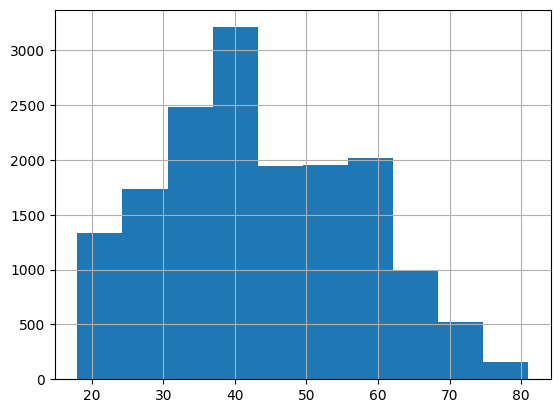

In [391]:
merged_hourAverage['age'].hist()

In [398]:
merged_hourAverage['ladder'].value_counts()

ladder
5     3505
6     2839
4     2613
3     2600
7     2425
2     1002
8      880
9      226
1      215
10      53
Name: count, dtype: int64

In [397]:
merged_hourAverage.ladder[merged_hourAverage.ladder == 'Bottom Rung 1'] = 1
merged_hourAverage.ladder[merged_hourAverage.ladder == 'Top Rung 10'] = 10
merged_hourAverage['ladder'] = merged_hourAverage['ladder'].astype('int64')

/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_37560/2023395855.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  merged_hourAverage.ladder[merged_hourAverage.ladder == 'Bottom Rung 1'] = 1
/var/folders/76/5w1g8h3d1y53y5vcpx55t

<Axes: >

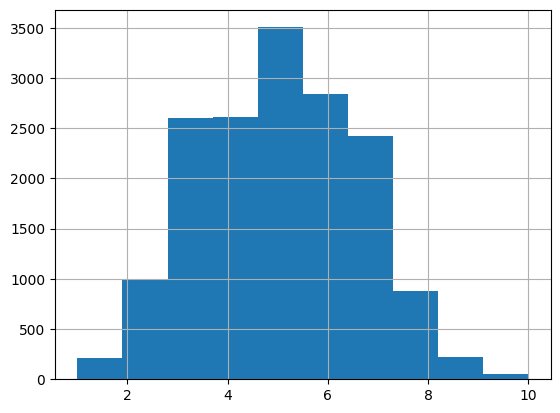

In [399]:
merged_hourAverage['ladder'].hist()

In [400]:
merged_hourAverage['gender'].value_counts()

gender
male      9097
female    6929
other      332
Name: count, dtype: int64

In [408]:
merged_hourAverage['binary_female'] = 0
merged_hourAverage.binary_female[merged_hourAverage.gender == 'female'] = 1

/var/folders/76/5w1g8h3d1y53y5vcpx55tgl00000gn/T/ipykernel_37560/4267222069.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  merged_hourAverage.binary_female[merged_hourAverage.gender == 'female'] = 1
/var/folders/76/5w1g8h3d1y53y5vcpx55t

In [410]:
merged_hourAverage['binary_female'].value_counts()

binary_female
0    9429
1    6929
Name: count, dtype: int64

In [412]:
merged_hourAverage[['predicted_angry_1hourAverage','pre_survey_angry', 'angry', 'age', 'binary_female']].corr()

predicted_angry_1hourAverage  pre_survey_angry  \
predicted_angry_1hourAverage                      1.000000          0.069600   
pre_survey_angry                                  0.069600          1.000000   
angry                                             0.182878          0.313436   
age                                               0.155468         -0.047851   
binary_female                                    -0.061925         -0.031496   

                                 angry       age  binary_female  
predicted_angry_1hourAverage  0.182878  0.155468      -0.061925  
pre_survey_angry              0.313436 -0.047851      -0.031496  
angry                         1.000000  0.031922      -0.058398  
age                           0.031922  1.000000       0.091626  
binary_female                -0.058398  0.091626       1.000000

array([[<Axes: title={'center': 'predicted_angry_1hourAverage'}>,
        <Axes: title={'center': 'pre_survey_angry'}>],
       [<Axes: title={'center': 'angry'}>, <Axes: >]], dtype=object)

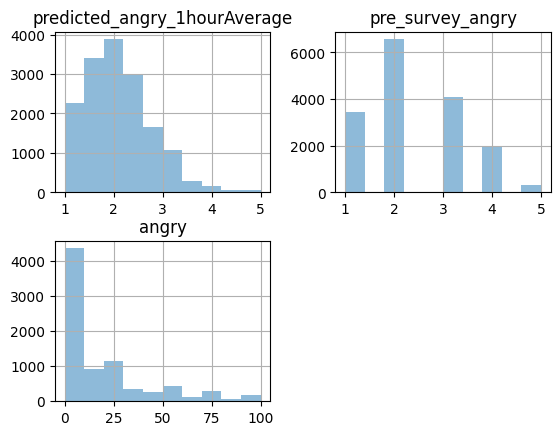

In [414]:
merged_hourAverage[['predicted_angry_1hourAverage','pre_survey_angry', 'angry']].hist(alpha=0.5)

In [406]:
#### This is a quick sanity check regarding the gender ####
# I quickly check merged1.csv file 's user_id against all user_ids
merged1 = pd.read_csv("merged1.csv")
pre_study1 = pd.read_csv("pre_study.csv")

merged1_user_id = merged1[['user_id']].drop_duplicates()
pre_study1_user_id = pre_study1[['participantId']].drop_duplicates()

print(len(merged1_user_id))
print(len(pre_study1_user_id))

1190
1662


In [407]:
merged_hourAverage_user_id = merged_hourAverage[['user_id']].drop_duplicates()
df1 = merged_hourAverage_user_id
df2 = pre_study1_user_id 
common_values = df1[df1['user_id'].isin(df2['participantId'])]
print(len(common_values))

1233


In [ ]:
#### Sanity Check over
# So I think the inconsistency is because merged1.csv contains info of less unique users
# than the current output files.
# I need to double check one more time throughout the whole calculation process. 

In [257]:
hourAverage = hourAverage[hourAverage['user_condition'] == "I_C"]
hourMax = hourMax[hourMax['user_condition'] == "I_C"]

In [258]:
"""
Compare Correlation of Specific Emotion: Angry, Calm, Sad, Excited
"""
predicted_columns = ['predicted_sad_1hourAverage', 'predicted_angry_1hourAverage','predicted_calm_1hourAverage','predicted_excited_1hourAverage']
actual_columns = ['sad', 'angry', 'calm', 'excited']

print("I_C Group: Compare Correlation of detected emotion to reported emotion")
for predicted, actual in zip(predicted_columns, actual_columns):
    hourAverage_filtered = hourAverage[hourAverage[actual].notna()]
    correlation = hourAverage_filtered[actual].corr(hourAverage_filtered[predicted])
    print(f"Correlation between {predicted} and {actual}: {correlation}")

I_C Group: Compare Correlation of detected emotion to reported emotion
Correlation between predicted_sad_1hourAverage and sad: 0.07012052723608488
Correlation between predicted_angry_1hourAverage and angry: 0.19739297600011435
Correlation between predicted_calm_1hourAverage and calm: 0.005926173028043705
Correlation between predicted_excited_1hourAverage and excited: 0.11173875757978814


In [259]:
predicted_columns = ['predicted_sad_1hourMax', 'predicted_angry_1hourMax','predicted_calm_1hourMax','predicted_excited_1hourMax']
actual_columns = ['sad', 'angry', 'calm', 'excited']

print("I_C Group: Compare Correlation of detected emotion to reported emotion")
for predicted, actual in zip(predicted_columns, actual_columns):
    hourMax_filtered = hourMax[hourMax[actual].notna()]
    correlation = hourMax_filtered[actual].corr(hourMax_filtered[predicted])
    print(f"Correlation between {predicted} and {actual}: {correlation}")

I_C Group: Compare Correlation of detected emotion to reported emotion
Correlation between predicted_sad_1hourMax and sad: 0.06578685149125413
Correlation between predicted_angry_1hourMax and angry: 0.11380774809579262
Correlation between predicted_calm_1hourMax and calm: -0.0008276916990750727
Correlation between predicted_excited_1hourMax and excited: -0.0025307249109250774


### regression analysis

In [260]:
hourAverage = hourAverage[hourAverage['user_condition'] == "I_C"]
hourMax = hourMax[hourMax['user_condition'] == "I_C"]

In [355]:
pre_study_test = pd.read_csv("pre_study.csv")
print(len(pre_study_test['participantId']))

1662


In [ ]:
batch_output = pd.read_csv("")